Developing Countries Development Predictor 
Utilizing public datasets from the United Nations to process development indicators. Contains EDA for the processed poverty and resources data. 
Implements SARIMAX And Neural Nets to model future indicator data and guage developmental thresholds for each country for the next decade.

Import statements and loading geopandas package

In [173]:
import pandas as pd
import scipy
import numpy as np
import time
import json
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 
import io      
import bokeh.io
from sklearn.impute import KNNImputer 
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Slider, HoverTool
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook
from bokeh.layouts import widgetbox, row, column
from bokeh.resources import INLINE
import seaborn as sn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import datetime
from pylab import rcParams


In [174]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp

!pip install --upgrade shapely

!pip install --upgrade descartes
import geopandas as gpd

### Part 1: Data Preparation/Cleanup

As part of data cleanup, we go through data we hand selected from world bank. World bank has public data on each category of development including Poverty, Health, Gender, the Public Sector, the Environment, Education, National Accounts (information on GDP etc), Transportation, Debt, Financial Services, Social Health, and Social Protection and Labor for each year from 1985 to 2019. We will first add data for years 1990 to 2015 and then add remaining data. The other years have very limited data. Out of these categories our goal was to find 12 particular indicators out of these categories that can help us sucessfully predict which year a country is developed (1) or not (0) based on these indicators. 

To find these indicators we go through the following steps:
1.   We go through each category of development from the World bank website.
2.   We only choose indicators in each category that has data for more than 180 countries (there are 193 recognized countries total excluding sovereign territories), since we will use KKN Imputer to fill in values that are missing. We ideally do this so we are not imputing data for too many indicator values as that will give us a drastically low accurancy while predicting developed or not.
3. We set threshold (thresh = 23) for number of years of data as 23. Out of 25 years, we need data for at least 23 years for the same reasons as above. 
4. After finding all indicators in each category we find the best indicator out for each category dependent on which are the best dvelopmental factors. (We use a reserach study conducted by NPO World Outreach to manually select the best indicators for development absed on their rubric out of the data we have)



In [175]:
na_df = pd.read_csv("NationalAccounts.csv")
#replace .. with null values
na_df = na_df.replace('..',np.NaN)
# need data for at least 23 years, else drop the entire indicator row
na_df = na_df.dropna(axis=0, thresh = 23)
# we do not need the series and country code columns
na_df = na_df.drop(columns=['Series Code', 'Country Code'])
# only need year values (related cleanup)
na_df.columns = na_df.columns.str[0:4]
na_df = na_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
# we print number of countries and number of indicators we have in the dataframe
# after the conditions we placed are established/cleaned
print('Number of countries in dataframe:', na_df['Country'].nunique())
print('Number of indicators in dataframe', na_df['Indicator Name'].nunique())
na_df.reset_index()
# we print out how many countries have data for each indicator for each year
na_df = na_df.groupby(by = 'Indicator Name').count()
# by teh metrics we set above we only want data if tehre is at least 180 countries
#represented amongst ALL years of data
na_df = na_df[na_df['Country'] >= 180]
#we print out the dataframe
na_df

Number of countries in dataframe: 193
Number of indicators in dataframe 233


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adjusted savings: carbon dioxide damage (current US$),186,163,164,185,185,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186
Adjusted savings: education expenditure (% of GNI),186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186
Adjusted savings: energy depletion (current US$),185,185,185,185,185,185,185,185,185,185,185,184,184,184,184,184,184,185,185,185,185,185,185,185,185,185,185
Adjusted savings: mineral depletion (current US$),193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193
GDP (constant LCU),180,161,162,165,166,167,177,177,180,180,180,180,180,180,180,180,180,180,180,180,180,179,179,178,178,178,177
GDP (current LCU),182,168,170,171,172,173,181,181,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,181,181,181,180
GDP (current US$),180,166,162,166,169,172,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,179,179,179,178
GDP per capita (constant LCU),180,161,162,164,165,166,177,177,180,180,180,180,180,180,180,180,180,180,180,180,180,179,179,178,178,178,177
GDP per capita (current LCU),182,168,170,170,171,172,181,181,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,181,181,181,180


Out of curiosity we want to see if the countries we are missing data for are different amonst two different indicators in this catagory. We take two random indicators and find which ountries are missing and compare them. We noticed that the countries missing data are very different amongst indicators we cannot just omit data for a few countries that have no data without having a significant biases/ skewed results. 

For example for the education expenditure indicator we were msising data for the UAE, Bosnia/Herzegovinia, DPRK, Tuvalu, Nauro, Palau, and Montegnero and for Carbon dioxide damage we were missing data for South sudan, Monaco, Serbia, Leichtenstein, Montenegro, San Marino, and Timor Leste, The only overlapping country presnet in both these sets of countries is Montenegro where no data was found for either of these two indicators. Based on this we can reasonably presume, that the countries with missing data are different for each indicator. 


In [176]:
na_df = pd.read_csv("NationalAccounts.csv")
na_df = na_df.replace('..',np.NaN)
na_df = na_df.dropna(axis=0, thresh = 23)
na_df = na_df.drop(columns=['Series Code', 'Country Code'])
na_df.columns = na_df.columns.str[0:4]
na_df = na_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
countries = na_df['Country'].unique().tolist()
na_df = na_df[na_df['Indicator Name'] == 'Adjusted savings: education expenditure (% of GNI)']
na_df = na_df['Country'].tolist()
# we subtract the set of countries missing from the set of all countries and find teh countries that 
# are missing for this particular indicator
countries_missing_education = list(set(countries) - set(na_df))
countries_missing_education

['Montenegro',
 "Korea, Dem. People's Rep.",
 'Palau',
 'United Arab Emirates',
 'Bosnia and Herzegovina',
 'Tuvalu',
 'Nauru']

In [177]:
na_df = pd.read_csv("NationalAccounts.csv")
na_df = na_df.replace('..',np.NaN)
na_df = na_df.dropna(axis=0, thresh = 23)
na_df = na_df.drop(columns=['Series Code', 'Country Code'])
na_df.columns = na_df.columns.str[0:4]
na_df = na_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
countries = na_df['Country'].unique().tolist()
na_df = na_df[na_df['Indicator Name'] == 'Adjusted savings: carbon dioxide damage (current US$)']
na_df = na_df['Country'].tolist()
countries_missing_CO2 = list(set(countries) - set(na_df))
countries_missing_education

['Montenegro',
 "Korea, Dem. People's Rep.",
 'Palau',
 'United Arab Emirates',
 'Bosnia and Herzegovina',
 'Tuvalu',
 'Nauru']

We replicate this analysis with the parameters we described for the National Accounts category for every category group and analyze the indicators till we find 12 indicators that accuartely described development according to our development research article. We will print out the dataframe containing indicators displayed for each of these cateories with the values of datapoints representing how many datapoints (countries) are available for each indicator for each year. Some of the dataframes contain no data as they did not meet our treshold requirements we set in the instructions above. We strictly adhere to these requirements since without enough data our model will not be a great predictor of development. This was because the world bank did not collect enough data as mechanisms were not present during most years as they explained on their website! Note: we only expect 180 countries to be represnetd for each indicator across all years, so a few years may have less than or greater than 180 datapoints. We are only interested the aggregate amount of datapoints across all years.

In [178]:
#in this dataframe we can see that before thed drop based of 180 countries we had 93 indicators present.
# However, even though it states 188 countries were present befroe drop, each indicator had less than 180 datapoints
# so, none of the indicatros could be used for our analysis unfortunately
debt_df = pd.read_csv("Debt.csv")
debt_df = debt_df.replace('..',np.NaN)
debt_df = debt_df.dropna(axis=0, thresh = 23)
debt_df = debt_df.drop(columns=['Series Code', 'Country Code'])
debt_df.columns = debt_df.columns.str[0:4]
debt_df = debt_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print('Number of countries before drop:', debt_df['Country'].nunique())
print('Number of indicators before drop', debt_df['Indicator Name'].nunique())
debt_df.reset_index()
debt_df = debt_df.groupby(by = 'Indicator Name').count()
debt_df = debt_df[debt_df['Country'] >= 180]
print('Number of countries in dataframe:', len(debt_df.columns)-1)
print('Number of indicators in dataframe', len(debt_df.index))
debt_df

Number of countries before drop: 188
Number of indicators before drop 93
Number of countries in dataframe: 26
Number of indicators in dataframe 0


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [179]:
education_df = pd.read_csv("Education_ds.csv")
education_df = education_df.replace('..',np.NaN)
education_df = education_df.dropna(axis=0, thresh = 22)
education_df = education_df.drop(columns=['Series Code', 'Country Code'])
education_df.columns = education_df.columns.str[0:4]
education_df = education_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(education_df['Country'].nunique())
print(education_df['Indicator Name'].nunique())
education_df.reset_index()
education_df = education_df.groupby(by = 'Indicator Name').count()
education_df = education_df[education_df['Country'] >= 180]
education_df

192
121


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Lower secondary school starting age (years),192,191,191,191,191,191,191,191,191,192,192,192,192,192,192,192,192,192,192,192,192,192,191,191,192,192,192
"Primary education, duration (years)",192,191,191,191,191,191,191,191,191,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192
Primary school starting age (years),192,191,191,191,191,191,191,191,191,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192
"Secondary education, duration (years)",192,191,191,191,191,191,191,191,191,192,192,192,192,192,192,192,192,192,192,192,192,192,191,191,192,192,192


In [180]:
environment_df = pd.read_csv("Environment_ds.csv")
environment_df = environment_df.replace('..',np.NaN)
environment_df = environment_df.dropna(axis=0, thresh = 24)
environment_df = environment_df.drop(columns=['Series Code', 'Country Code'])
environment_df.columns = environment_df.columns.str[0:4]
environment_df = environment_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(environment_df['Country'].nunique())
print(environment_df['Indicator Name'].nunique())
environment_df.reset_index()
environment_df = environment_df.groupby(by = 'Indicator Name').count()
environment_df = environment_df[environment_df['Country'] >= 185]
environment_df

193
94


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agricultural land (% of land area),187,162,165,184,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187
Agricultural land (sq. km),187,162,165,184,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187
Agricultural methane emissions (thousand metric tons of CO2 equivalent),191,188,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191
Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent),191,188,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191
Arable land (% of land area),185,160,163,182,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185
Arable land (hectares per person),185,160,163,181,184,184,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185
Arable land (hectares),185,160,163,182,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185
CO2 emissions (kt),191,190,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191
CO2 emissions (metric tons per capita),191,190,191,190,190,190,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191


In [181]:
fs_df = pd.read_csv("FinancialSector.csv")
fs_df = fs_df.replace('..',np.NaN)
fs_df = fs_df.dropna(axis=0, thresh = 23)
fs_df = fs_df.drop(columns=['Series Code', 'Country Code'])
fs_df.columns = fs_df.columns.str[0:4]
fs_df = fs_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(fs_df['Country'].nunique())
print(fs_df['Indicator Name'].nunique())
fs_df.reset_index()
fs_df = fs_df.groupby(by = 'Indicator Name').count()
fs_df = fs_df[fs_df['Country'] >= 170]
fs_df

173
57


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [182]:
gender_df = pd.read_csv("Gender.csv")
gender_df = gender_df.replace('..',np.NaN)
gender_df = gender_df.dropna(axis=0, thresh = 24)
gender_df = gender_df.drop(columns=['Series Code', 'Country Code'])
gender_df.columns = gender_df.columns.str[0:4]
gender_df = gender_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(gender_df['Country'].nunique())
print(gender_df['Indicator Name'].nunique())
gender_df.reset_index()
gender_df = gender_df.groupby(by = 'Indicator Name').count()
gender_df = gender_df[gender_df['Country'] >= 185]
gender_df

185
1


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Women Business and the Law Index Score (scale 1-100),185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185


In [183]:
health_df = pd.read_csv("Health.csv")
health_df = health_df.replace('..',np.NaN)
health_df = health_df.dropna(axis=0, thresh = 24)
health_df = health_df.drop(columns=['Series Code', 'Country Code'])
health_df.columns = health_df.columns.str[0:4]
health_df = health_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(health_df['Country'].nunique())
print(health_df['Indicator Name'].nunique())
health_df.reset_index()
health_df = health_df.groupby(by = 'Indicator Name').count()
health_df = health_df[health_df['Country'] >= 180]
#health_df = health_df.transpose()
health_df

193
119


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Adolescent fertility rate (births per 1,000 women ages 15-19)",183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183
Age dependency ratio (% of working-age population),183,183,183,182,182,182,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,182,182,182,182
"Age dependency ratio, old (% of working-age population)",183,183,183,182,182,182,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,182,182,182,182
"Age dependency ratio, young (% of working-age population)",183,183,183,182,182,182,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,182,182,182,182
"Birth rate, crude (per 1,000 people)",186,185,186,185,185,185,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,185,186,185,185,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Probability of dying among adolescents ages 15-19 years (per 1,000)",192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192
"Probability of dying among children ages 5-9 years (per 1,000)",192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192
"Probability of dying among youth ages 20-24 years (per 1,000)",192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192


In [184]:
na_df = pd.read_csv("NationalAccounts.csv")
na_df = na_df.replace('..',np.NaN)
na_df = na_df.dropna(axis=0, thresh = 24)
na_df = na_df.drop(columns=['Series Code', 'Country Code'])
na_df.columns = na_df.columns.str[0:4]
na_df = na_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(na_df['Country'].nunique())
print(na_df['Indicator Name'].nunique())
na_df.reset_index()
na_df = na_df.groupby(by = 'Indicator Name').count()
na_df = na_df[na_df['Country'] >= 185]
na_df

193
232


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adjusted savings: carbon dioxide damage (current US$),186,163,164,185,185,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186
Adjusted savings: education expenditure (% of GNI),186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186,186
Adjusted savings: energy depletion (current US$),185,185,185,185,185,185,185,185,185,185,185,184,184,184,184,184,184,185,185,185,185,185,185,185,185,185,185
Adjusted savings: mineral depletion (current US$),193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193


In [185]:
# here is a good example of why we also print out number of datapoints (country data) avaiable
# for each year and indicator. Even though there are 93 country data present in aggregate for each indicator we can see there 
# virtually no data present in many of the years. This is why we can't use most of the indicators since data is not available for a huge chunk of the
# years even though it is aviable for all the countreis after year 2000 etc.
poverty_df = pd.read_csv("Poverty.csv")
poverty_df = poverty_df.replace('..',np.NaN)
poverty_df = poverty_df.dropna(axis=0, thresh = 1)
poverty_df = poverty_df.drop(columns=['Series Code', 'Country Code'])
poverty_df.columns = poverty_df.columns.str[0:4]
poverty_df = poverty_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(poverty_df['Country'].nunique())
print(poverty_df['Indicator Name'].nunique())
poverty_df.reset_index()
poverty_df = poverty_df.groupby(by = 'Indicator Name').count()
poverty_df = poverty_df[poverty_df['Country'] >= 160]
poverty_df

195
28


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Annualized average growth rate in per capita real survey mean consumption or income, bottom 40% of population (%)",193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
"Annualized average growth rate in per capita real survey mean consumption or income, total population (%)",193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Gini index (World Bank estimate),193,17,19,32,21,26,37,32,27,37,31,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81
Income share held by fourth 20%,193,17,19,32,21,26,37,32,27,37,31,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81
Income share held by highest 10%,193,17,19,32,21,26,37,32,27,37,31,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81
Income share held by highest 20%,193,17,19,32,21,26,37,32,27,37,31,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81
Income share held by lowest 10%,193,17,19,32,21,26,37,32,27,37,30,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81
Income share held by lowest 20%,193,17,19,32,21,26,37,32,27,37,30,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81
Income share held by second 20%,193,17,19,32,21,26,37,32,27,37,31,50,36,53,58,69,74,73,69,73,76,81,75,83,75,82,81


In [186]:
public_data = pd.read_csv("PublicSector data.csv")
public_data = public_data.replace('..',np.NaN)
public_data = public_data.dropna(axis=0, thresh = 24)
public_data = public_data.drop(columns=['Series Code', 'Country Code'])
public_data.columns = public_data.columns.str[0:4]
public_data = public_data.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(public_data['Country'].nunique())
print(public_data['Indicator Name'].nunique())
public_data.reset_index()
public_data = public_data.groupby(by = 'Indicator Name').count()
public_data = public_data[public_data['Country'] >= 180]
public_data

189
35


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
DEC alternative conversion factor (LCU per US$),184,177,176,178,179,180,183,183,183,183,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184,184,183


In [187]:
sh_df = pd.read_csv("SocialHealth.csv")
sh_df = sh_df.replace('..',np.NaN)
sh_df = sh_df.dropna(axis=0, thresh = 24)
sh_df = sh_df.drop(columns=['Series Code', 'Country Code'])
sh_df.columns = sh_df.columns.str[0:4]
sh_df = sh_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(sh_df['Country'].nunique())
print(sh_df['Indicator Name'].nunique())
sh_df.reset_index()
sh_df = sh_df.groupby(by = 'Indicator Name').count()
sh_df = sh_df[sh_df['Country'] >= 180]
sh_df

0
0


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [188]:
spl_df = pd.read_csv("SocialProtectionAndLabor.csv")
spl_df = spl_df.replace('..',np.NaN)
spl_df = spl_df.dropna(axis=0, thresh = 24)
spl_df = spl_df.drop(columns=['Series Code', 'Country Code'])
spl_df.columns = spl_df.columns.str[0:4]
spl_df = spl_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(spl_df['Country'].nunique())
print(spl_df['Indicator Name'].nunique())
spl_df.reset_index()
spl_df = spl_df.groupby(by = 'Indicator Name').count()
spl_df = spl_df[spl_df['Country'] >= 180]
spl_df

181
94


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [189]:
transport_df = pd.read_csv("Transportation.csv")
transport_df = transport_df.replace('..',np.NaN)
transport_df = transport_df.dropna(axis=0, thresh = 24)
transport_df = transport_df.drop(columns=['Series Code', 'Country Code'])
transport_df.columns = transport_df.columns.str[0:4]
transport_df = transport_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
print(transport_df['Country'].nunique())
print(transport_df['Indicator Name'].nunique())
transport_df.reset_index()
transport_df = transport_df.groupby(by = 'Indicator Name').count()
transport_df = transport_df[transport_df['Country'] >= 185]
transport_df

190
23


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Indicator Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fixed telephone subscriptions,187,185,185,187,187,187,187,187,187,187,187,187,187,187,186,185,184,182,184,184,186,187,186,187,186,186,187
Fixed telephone subscriptions (per 100 people),187,185,185,187,187,187,187,187,187,187,187,187,187,187,186,185,184,182,184,184,186,187,186,187,186,186,186
Individuals using the Internet (% of population),185,185,185,185,185,185,185,158,168,174,180,180,182,183,178,179,180,180,185,184,183,182,184,180,181,180,176
Mobile cellular subscriptions,185,185,181,181,181,181,183,185,184,185,185,185,185,185,185,184,184,183,185,183,184,185,184,185,185,184,185
Mobile cellular subscriptions (per 100 people),185,185,180,181,181,181,183,185,184,185,185,185,185,185,185,184,184,183,185,183,184,185,184,185,185,184,185


In [190]:
# we reset df values after we find best indicators since we altered these dataframes while doing the analysis
debt = pd.read_csv("Debt.csv")
education = pd.read_csv("Education_ds.csv")
environment = pd.read_csv("Environment_ds.csv")
financial = pd.read_csv("FinancialSector.csv")
gender = pd.read_csv("Gender.csv")
health = pd.read_csv("Health.csv")
nationalAccounts = pd.read_csv("NationalAccounts.csv")
poverty = pd.read_csv("Poverty.csv")
publicSector = pd.read_csv("PublicSector data.csv")
socialHealth = pd.read_csv("SocialHealth.csv")
socialProtectionAndLabor = pd.read_csv("SocialProtectionAndLabor.csv")
transportation = pd.read_csv("Transportation.csv")
# we combine all dataframes into one massive dataframe
combined_df = pd.concat([debt, education, environment, financial, gender, health], axis=0)
combined_df = pd.concat([combined_df, nationalAccounts, poverty, publicSector, socialHealth, socialProtectionAndLabor, transportation], axis=0)
# change name of country code to just CODE for readability
combined_df = combined_df.rename(columns={'Country Code': 'CODE'})

# change .. (missing data) to null values
combined_df = combined_df.replace('..',np.NaN)
# cleaning up combined dataset
combined_df = combined_df.drop(columns=['Series Code'])
combined_df.columns = combined_df.columns.str[0:4]
combined_df = combined_df.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
#we extract only the rows of the indicators we want out of our massive dataframe of all 1500+ indicators based off of our analysis
combined_df = combined_df[(combined_df['Indicator Name'] == 'GDP per capita (current US$)') |
                          (combined_df['Indicator Name'] == 'Rural population (% of total population)') |
                          (combined_df['Indicator Name'] == 'Population growth (annual %)') |
                          (combined_df['Indicator Name'] == 'Mortality rate, under-5 (per 1,000 live births)') |
                          (combined_df['Indicator Name'] == 'Birth rate, crude (per 1,000 people)') |
                          (combined_df['Indicator Name'] == 'Life expectancy at birth, total (years)') |
                          (combined_df['Indicator Name'] == 'Adjusted savings: education expenditure (% of GNI)') |
                          (combined_df['Indicator Name'] == 'Immunization, DPT (% of children ages 12-23 months)') |
                          (combined_df['Indicator Name'] == 'Immunization, measles (% of children ages 12-23 months)') |
                          (combined_df['Indicator Name'] == 'Individuals using the Internet (% of population)') |
                          (combined_df['Indicator Name'] == 'Renewable energy consumption (% of total final energy consumption)') |
                          (combined_df['Indicator Name'] == 'CO2 emissions (metric tons per capita)')]

#we store indicator code and ocuntry name in lists and move them to front of dataframe to make dataframe more readable
indicator_name = combined_df['Indicator Name'].tolist()
code_name = combined_df['CODE'].tolist()
country_name = combined_df['Country'].tolist()
combined_df = combined_df.drop(columns=['Country', 'Indicator Name'])
combined_imputed = combined_df
#change column names to years
combined_df = pd.DataFrame(combined_imputed, columns=['1990', '1991', '1992', '1993', '1994', '1995', '1996',
                                                      '1997', '1998', '1999', '2000', '2001', '2002', '2003',
                                                      '2004', '2005', '2006', '2007', '2008', '2009', '2010',
                                                      '2011', '2012', '2013', '2014', '2015'])
combined_df.insert(0, "Indicator Name", indicator_name, True)
combined_df.insert(0, "Country", country_name, True)
combined_df.insert(0, "CODE", code_name, True)
combined2_df = combined_df
combined2_df

,CODE,Country,Indicator Name,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
32,AFG,Afghanistan,CO2 emissions (metric tons per capita),0.238472916123355,0.20603028073656,0.0987191160179498,0.0859856046188432,0.0761314539561651,0.0690201164374886,0.0625880343135185,0.0568266177530693,0.0531974990082466,0.040652730150598,0.0370549371204185,0.0374878650392429,0.0486708995010525,0.0570080382600792,0.0456996082249427,0.0639269698296666,0.0733929460601948,0.0870831291861248,0.158356377673251,0.211306250868557,0.297065211570221,0.407073503097594,0.335351023308404,0.263715760645502,0.234036914423758,0.232175631246749
112,AFG,Afghanistan,Renewable energy consumption (% of total final...,15.9245316828932,17.0364435282942,26.5216286544368,30.5856670489932,32.7962505504008,35.0756402917937,37.9457475001443,41.4326008731029,44.0943368543633,52.1857743728053,54.2431983947754,54.0550003051758,43.7711982727051,42.2761001586914,49.8432006835938,40.8591995239258,37.1372985839844,33.8625984191895,21.3437004089355,17.8504009246826,14.8990001678467,11.559100151062,14.404899597168,17.1049995422363,20.770299911499,20.2737998962402
119,AFG,Afghanistan,Rural population (% of total population),78.823,78.734,78.645,78.556,78.466,78.376,78.286,78.195,78.105,78.014,77.922,77.831,77.739,77.647,77.5,77.297,77.093,76.887,76.68,76.472,76.263,76.052,75.84,75.627,75.413,75.197
170,ALB,Albania,CO2 emissions (metric tons per capita),1.84084061606394,1.25811576501704,0.689859284104687,0.641405614065312,0.667178793940271,0.611710203702635,0.621836956875134,0.470097808931287,0.575350084544499,0.955359308384195,1.026213108529,1.0522280929869,1.22910118288698,1.35214448140818,1.41727335767255,1.35149180454706,1.35336220283257,1.42086728796502,1.41484755272088,1.47565225025013,1.57225093811545,1.73482330790188,1.57909199452076,1.65452427763954,1.80678854066866,1.75998705871449
250,ALB,Albania,Renewable energy consumption (% of total final...,25.5180876255371,32.9981742379589,46.8133288085849,51.152042295146,51.4595442246242,50.6097095765374,51.63636055808,55.953349416169,49.9833654433978,42.7183134087746,41.4449996948242,39.125301361084,35.8958015441895,33.7517013549805,35.934700012207,36.8683013916016,31.7098999023438,32.100399017334,35.9118995666504,37.2151985168457,37.1137008666992,35.9611015319824,40.0466995239258,41.2869987487793,38.6973991394043,38.6255989074707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,VEN,"Venezuela, RB",Individuals using the Internet (% of population),0,0,0.012082134,0.041587233,0.055486978,0.122214848,0.24826058,0.390959318,1.383990391,2.839825767,3.359597465,4.636000948,4.910446327,7.499963465,8.404469592,12.55299791,15.22471148,20.83,25.88,32.7,37.37,40.22,49.05008307,54.9,57,NaN
7196,VNM,Vietnam,Individuals using the Internet (% of population),0,0,0,0,0,0,0.000134813,0.003981962,0.013078543,0.128926663,0.254248276,1.265651236,1.854999236,3.780280814,7.642408528,12.73992929,17.25456172,20.75544477,23.92,26.55,30.65,35.07,36.8,38.5,41,45
7234,YEM,"Yemen, Rep.",Individuals using the Internet (% of population),0,0,0,0,0,0,0.000621081,0.015025295,0.023323243,0.056628675,0.082500387,0.090802459,0.518796032,0.6047341,0.881222989,1.048597934,1.247824049,5.01,6.89,9.96,12.35,14.905,17.4465,20,22.55,24.08540947
7272,ZMB,Zambia,Individuals using the Internet (% of population),0,0,0,0,0.006776105,0.008783623,0.009069176,0.009329658,0.030226183,0.147053172,0.191071643,0.233129556,0.477750907,0.980483039,2.013549532,2.851752261,4.159913394,4.87,5.55,6.31,10,11.5,NaN,NaN,NaN,NaN


In [191]:
#collect values for each of these indicators from years 1985-1990 and 2015-2019 in dataframe
#called extra_data and add them to our dataframe
extra_data = pd.read_csv("extra_data.csv")
extra_data = extra_data.replace('..',np.NaN)
extra_data = extra_data.drop(columns=['Series Code'])
extra_data = extra_data.rename(columns={'Country Code': 'CODE'})
extra_data.columns = extra_data.columns.str[0:4]
extra_data = extra_data.rename(columns={'Coun': 'Country', 'Seri': 'Indicator Name'})
extra_data.dropna(how ='all')
#drop irrelevant rows
extra_data = extra_data[extra_data['Indicator Name'] != 'Data from database: World Development Indicators']
extra_data = extra_data[extra_data['Indicator Name'] != 'Last Updated: 11/23/2021']
extra_data.drop(extra_data.tail(5).index,inplace = True)
extra_data.dropna(how ='all')
extra_data = extra_data[extra_data['Country'] != 'NaN']
combined_df = extra_data
#want to find missing country rows within both combined_df (combined2_df is the old datafraem without extra data)
#combined_df is new dataframe with the extra_data df concatenated with the old combined_df 
x = combined2_df['Country'].unique().tolist()
y = combined_df['Country'].unique().tolist()
missing = list(set(x) - set(y))
#want to add country codes for the geoplot in EDA since will be useing same dataframe
result = pd.merge(combined2_df, combined_df, how="left",on=["Indicator Name","Country", 'CODE'])
result = pd.melt(result, id_vars=['Country', 'CODE'], value_vars=['1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])
result = result.groupby(by=['Country', 'CODE', 'variable'])['value'].apply(list)
result = pd.DataFrame(result)
result['CO2 emissions (metric tons per capita)'], result['Renewable energy consumption (% of total final energy consumption)'], result['Rural population (% of total population)'], result['Birth rate, crude (per 1,000 people)'], result['Immunization, DPT (% of children ages 12-23 months)'], result['Immunization, measles (% of children ages 12-23 months)'], result['Life expectancy at birth, total (years)'], result['Mortality rate, under-5 (per 1,000 live births)'], result['Population growth (annual %)'], result['Adjusted savings: education expenditure (% of GNI)'], result['GDP per capita (current US$)'], result['Individuals using the Internet (% of population)'] = zip(*result.pop('value'))


In [192]:
#we will now create a column with data on whterh a country is developed or not. 
#This data is according to HDI indicators telling us since when a country was considered a devloping country
#so far no country at least on teh abssi of HDI was developed and is not back to teh developing stage
#so once a country becomes developed it normally stays dveloped so when its index geos from 0 to 1, it stays 1
#each country is populated with 0s for each year and then we replace the country and its year row with 1s after the year each country got developed
result['developed or not'] = 0
result = result.reset_index()
result = result.rename(columns = {'variable' : 'Years'})
result.loc[(result['Country'] == 'Lithuania') & (result['Years'] >= '2005'), 'developed or not'] = 1
#for x in (result[(result['Country'] == 'Lithuania') & (result['Years'] >= '2005')]):
 # result['developed or not'] = 1
# have to manually enter data for each country
#all other countries are assumed to be undeveloped so are populated with 0s.
x = result[(result['Country'] == 'Lithuania') & (result['Years'] >= '2002')]
result.loc[(result['Country'] == 'Latvia') & (result['Years'] >= '2005'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Estonia') & (result['Years'] >= '2003'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Israel') & (result['Years'] >= '1991'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Slovenia') & (result['Years'] >= '1998'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Czech Republic') & (result['Years'] >= '2001'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Slovak Republic') & (result['Years'] >= '2006'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Portugal') & (result['Years'] >= '2005'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Korea, Rep.') & (result['Years'] >= '1999'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Greece') & (result['Years'] >= '2001'), 'developed or not'] = 1
result.loc[(result['Country'] == 'New Zealand') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Spain') & (result['Years'] >= '1995'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Finland') & (result['Years'] >= '1994'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Ireland') & (result['Years'] >= '1996'), 'developed or not'] = 1
result.loc[(result['Country'] == 'United Kingdom') & (result['Years'] >= '1992'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Iceland') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Italy') & (result['Years'] >= '1995'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Sweden') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Australia') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Belgium') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Canada') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'France') & (result['Years'] >= '1993'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Austria') & (result['Years'] >= '1992'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Germany') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Japan') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Luxembourg') & (result['Years'] >= '1992'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Denmark') & (result['Years'] >= '1991'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Netherlands') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'United States') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Norway') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Switzerland') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Andorra') & (result['Years'] >= '1990'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Chile') & (result['Years'] >= '2007'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Hungary') & (result['Years'] >= '2005'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Poland') & (result['Years'] >= '2003'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Malta') & (result['Years'] >= '2003'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Cyprus') & (result['Years'] >= '2001'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Singapore') & (result['Years'] >= '1999'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Croatia') & (result['Years'] >= '2007'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Uruguay') & (result['Years'] >= '2014'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Bahamas, The') & (result['Years'] >= '2016'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Turkey') & (result['Years'] >= '2015'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Kuwait') & (result['Years'] >= '2014'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Oman') & (result['Years'] >= '2012'), 'developed or not'] = 1
result.loc[(result['Country'] == 'San Marino') & (result['Years'] >= '2012'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Bahrain') & (result['Years'] >= '2012'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Saudi Arabia') & (result['Years'] >= '2010'), 'developed or not'] = 1
result.loc[(result['Country'] == 'United Arab Emirates') & (result['Years'] >= '2004'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Brunei Darussalam') & (result['Years'] >= '1999'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Qatar') & (result['Years'] >= '1996'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Costa Rica') & (result['Years'] >= '2019'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Panama') & (result['Years'] >= '2019'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Bulgaria') & (result['Years'] >= '2015'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Palau') & (result['Years'] >= '2013'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Romania') & (result['Years'] >= '2013'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Malaysia') & (result['Years'] >= '2016'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Kazakhstan') & (result['Years'] >= '2015'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Russian Federation') & (result['Years'] >= '2013'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Barbados') & (result['Years'] >= '2011'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Seychelles') & (result['Years'] >= '2013'), 'developed or not'] = 1
result.loc[(result['Country'] == 'St. Kitts and Nevis') & (result['Years'] >= '2013'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Trinidad and Tobago') & (result['Years'] >= '2005'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Liechtenstein') & (result['Years'] >= '2000'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Georgia') & (result['Years'] >= '2019'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Mauritius') & (result['Years'] >= '2019'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Serbia') & (result['Years'] >= '2019'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Nauru') & (result['Years'] >= '2019'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Montenegro') & (result['Years'] >= '2013'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Antigua and Barbuda') & (result['Years'] >= '2012'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Belarus') & (result['Years'] >= '2012'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Argentina') & (result['Years'] >= '2006'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Mexico') & (result['Years'] >= '1994'), 'developed or not'] = 1
result.loc[(result['Country'] == 'Monaco') & (result['Years'] >= '1994'), 'developed or not'] = 1
x = result[(result['Country'] == 'United States') & (result['Years'] >= '1980')]
# there are 5046 null values in this dataframe which we must compute using KNN Imputer as shown in class
#result.isna().sum().sum() 5046
result


,Country,CODE,Years,CO2 emissions (metric tons per capita),Renewable energy consumption (% of total final energy consumption),Rural population (% of total population),"Birth rate, crude (per 1,000 people)","Immunization, DPT (% of children ages 12-23 months)","Immunization, measles (% of children ages 12-23 months)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),Adjusted savings: education expenditure (% of GNI),GDP per capita (current US$),Individuals using the Internet (% of population),developed or not
0,Afghanistan,AFG,1985,0.293957030722544,NaN,81.003,49.735,15,14,46.761,209.3,-2.2045162396444,1.73337532467471,NaN,NaN,0
1,Afghanistan,AFG,1986,0.26777194992884,NaN,80.353,49.586,11,14,47.486,202.9,-1.70675553634083,1.77783376623295,NaN,NaN,0
2,Afghanistan,AFG,1987,0.26922950314782,NaN,79.686,49.418,25,31,48.211,196.4,-1.12798940191383,1.82229220779119,NaN,NaN,0
3,Afghanistan,AFG,1988,0.246823207558473,NaN,79.002,49.236,35,34,48.93,190.1,0.116007964937545,1.86675064934942,NaN,NaN,0
4,Afghanistan,AFG,1989,0.233882273405403,NaN,78.912,49.048,33,22,49.64,183.8,2.13629507171115,1.91120909090766,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750,Zimbabwe,ZWE,2015,0.897598359769294,81.4272003173828,67.615,33.981,87,86,59.534,62,1.66369350951633,1.91,1445.06970213198,22.7428181,0
6751,Zimbabwe,ZWE,2016,0.783302583301985,82.7926025390625,67.704,32.864,90,95,60.294,59.5,1.54929408793871,1.91,1464.58895715841,23.11998904,0
6752,Zimbabwe,ZWE,2017,0.718570495664028,83.4929962158203,67.763,31.732,89,90,60.812,58.2,1.45940581314681,1.91,1335.66506432532,24.4,0
6753,Zimbabwe,ZWE,2018,0.849792905399696,81.3636016845703,67.791,30.676,89,88,61.195,55.9,1.41038154233327,1.91,1352.16265310562,25,0


In [193]:
country = result['Country']
result = result.drop(columns=['Country'])
years = result['Years']
result = result.drop(columns=['Years'])
code = result['CODE']
result = result.drop(columns=['CODE'])
imputer = KNNImputer(n_neighbors=2)
df_filled = imputer.fit_transform(result)
combined_df = pd.DataFrame(df_filled, columns=['CO2 emissions (metric tons per capita)', 'Renewable energy consumption (% of total final energy consumption)', 'Rural population (% of total population)', 'Birth rate, crude (per 1,000 people)', 'Immunization, DPT (% of children ages 12-23 months)', 'Immunization, measles (% of children ages 12-23 months)', 'Life expectancy at birth, total (years)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Adjusted savings: education expenditure (% of GNI)', 'GDP per capita (current US$)', 'Individuals using the Internet (% of population)', 'Developed?'])
combined_df.insert(0, "Years", years, True)
combined_df.insert(0, "Country", country, True)
combined_df.insert(0, "CODE", code, True)
combined_df["Country-Year"] = combined_df["Country"] + "-" + combined_df["Years"].astype(str)
country_year = combined_df['Country-Year']
combined_df = combined_df.drop(columns=['Country', 'Years', 'Country-Year'])
combined_df.insert(0, "Country-Year", country_year, True)
combined_df['Developed?'] = combined_df['Developed?'].astype(int)
x = combined_df[combined_df['Developed?'] == 1].count()
x


Country-Year                                                          1235
CODE                                                                  1235
CO2 emissions (metric tons per capita)                                1235
Renewable energy consumption (% of total final energy consumption)    1235
Rural population (% of total population)                              1235
Birth rate, crude (per 1,000 people)                                  1235
Immunization, DPT (% of children ages 12-23 months)                   1235
Immunization, measles (% of children ages 12-23 months)               1235
Life expectancy at birth, total (years)                               1235
Mortality rate, under-5 (per 1,000 live births)                       1235
Population growth (annual %)                                          1235
Adjusted savings: education expenditure (% of GNI)                    1235
GDP per capita (current US$)                                          1235
Individuals using the Int

In [194]:
combined_df

,Country-Year,CODE,CO2 emissions (metric tons per capita),Renewable energy consumption (% of total final energy consumption),Rural population (% of total population),"Birth rate, crude (per 1,000 people)","Immunization, DPT (% of children ages 12-23 months)","Immunization, measles (% of children ages 12-23 months)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),Adjusted savings: education expenditure (% of GNI),GDP per capita (current US$),Individuals using the Internet (% of population),Developed?
0,Afghanistan-1985,AFG,0.293957,98.200987,81.003,49.735,15.0,14.0,46.761,209.3,-2.204516,1.733375,243.348702,0.000000,0
1,Afghanistan-1986,AFG,0.267772,98.200987,80.353,49.586,11.0,14.0,47.486,202.9,-1.706756,1.777834,552.721592,0.000000,0
2,Afghanistan-1987,AFG,0.269230,98.031153,79.686,49.418,25.0,31.0,48.211,196.4,-1.127989,1.822292,206.061674,0.000329,0
3,Afghanistan-1988,AFG,0.246823,90.426697,79.002,49.236,35.0,34.0,48.930,190.1,0.116008,1.866751,207.768134,0.018334,0
4,Afghanistan-1989,AFG,0.233882,93.149012,78.912,49.048,33.0,22.0,49.640,183.8,2.136295,1.911209,195.364724,0.019988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750,Zimbabwe-2015,ZWE,0.897598,81.427200,67.615,33.981,87.0,86.0,59.534,62.0,1.663694,1.910000,1445.069702,22.742818,0
6751,Zimbabwe-2016,ZWE,0.783303,82.792603,67.704,32.864,90.0,95.0,60.294,59.5,1.549294,1.910000,1464.588957,23.119989,0
6752,Zimbabwe-2017,ZWE,0.718570,83.492996,67.763,31.732,89.0,90.0,60.812,58.2,1.459406,1.910000,1335.665064,24.400000,0
6753,Zimbabwe-2018,ZWE,0.849793,81.363602,67.791,30.676,89.0,88.0,61.195,55.9,1.410382,1.910000,1352.162653,25.000000,0


### Part 2: Exploratory Data Analysis (EDA)

We graph the rural and immunization populations on a cloropleth world map to see how the rural population changed from 1990 to 2019. We also create a covariance matrix and a heat map to see the correlation between each of our 12 indices we will use to predict when a country will be considered developed.

In [195]:
# here we are importing the file of all the country's coordinates in order to map them out 
# we take them from a website cited at end of project
shapefile = 'graphing_data/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [196]:
# similar to as done on model, we take out antarctica since, there has obviously been no
# development in Antarctica 
print(gdf[gdf['country'] == 'Antarctica'])
gdf = gdf.drop(gdf.index[159])
gdf.info()

        country country_code                                           geometry
159  Antarctica          ATA  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 176 entries, 0 to 176
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   country       176 non-null    object  
 1   country_code  176 non-null    object  
 2   geometry      176 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 5.5+ KB


In [197]:
# We merge our existing data with the data we imported so the two datasets are now connected
# Now we have a final dataframe named merged2 with all teh ocuntries coordinates and their respective information
combined_df['Country'], combined_df['Year'] = combined_df['Country-Year'].str.split('-', 1).str
df_2016 = combined_df[combined_df['Year'] == '2016']
merged = gdf.merge(df_2016, left_on = 'country_code', right_on = 'CODE', how = 'left')
merged.fillna('No data', inplace = True)
df_1990 = combined_df[combined_df['Year'] == '1990']
merged2 = gdf.merge(df_1990, left_on = 'country_code', right_on = 'CODE', how = 'left')
merged2.fillna('No data', inplace = True)
merged2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


,country,country_code,geometry,Country-Year,CODE,CO2 emissions (metric tons per capita),Renewable energy consumption (% of total final energy consumption),Rural population (% of total population),"Birth rate, crude (per 1,000 people)","Immunization, DPT (% of children ages 12-23 months)","Immunization, measles (% of children ages 12-23 months)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),Adjusted savings: education expenditure (% of GNI),GDP per capita (current US$),Individuals using the Internet (% of population),Developed?,Country,Year
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji-1990,FJI,1.00196,53.094,58.389,28.888,97,84,65.379,28.9,0.546803,4.56648,1835.12,0,0,Fiji,1990
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania-1990,TZA,0.0749885,94.7849,81.116,43.986,78,80,50.206,165.1,3.19324,2.1,173.791,0,0,Tanzania,1990
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada-1990,CAN,15.1355,22.0208,23.418,15,88,89,77.422,8.2,1.50766,5.8,21448.4,0.361,1,Canada,1990
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States-1990,USA,19.4092,4.17546,24.7,16.7,90,90,75.2146,11.2,1.12965,4.4,23888.6,0.784729,1,United States,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Republic of Serbia,SRB,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",Serbia-1990,SRB,8.16109,15.4917,49.607,13.85,90,89,70.5973,27.9,0.0659326,4.39,3107.98,22.4232,0,Serbia,1990
172,Montenegro,MNE,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",Montenegro-1990,MNE,0,5.7308,51.963,16.487,96.5,98,74.627,16.5,-0.0328128,5.17857,6440.87,40.1,0,Montenegro,1990
173,Kosovo,KOS,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data,No data
174,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Trinidad and Tobago-1990,TTO,11.555,1.19302,45.876,20.72,82,70,68.086,30.4,0.678973,3.7,4150.28,0,0,Trinidad and Tobago,1990


In [198]:
#we load all json data into merged_jason and merged2.json
#json.dumps is a json encoder/decoder
merged_json = json.loads(merged.to_json())
merged2_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)
json2_data = json.dumps(merged_json)

In [199]:
# we cleanup this dataframe so we can prepare to create our cloropleth map
combined_df['Year'] = combined_df['Year'].str[0:4]
combined_df = combined_df[combined_df['Year'] != 'Biss']
combined_df = combined_df[combined_df['Year'] != 'Lest']
combined_df['Year'] = combined_df['Year'].astype(int)
combined_df['Year'].unique()
combined_df['CODE'].nunique()

191

In [200]:
combined_df = combined_df.rename(columns={'Rural population (% of total population)': 'rural', 'Immunization, DPT (% of children ages 12-23 months)' : 'immunization'})
combined_df

,Country-Year,CODE,CO2 emissions (metric tons per capita),Renewable energy consumption (% of total final energy consumption),rural,"Birth rate, crude (per 1,000 people)",immunization,"Immunization, measles (% of children ages 12-23 months)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),Adjusted savings: education expenditure (% of GNI),GDP per capita (current US$),Individuals using the Internet (% of population),Developed?,Country,Year
0,Afghanistan-1985,AFG,0.293957,98.200987,81.003,49.735,15.0,14.0,46.761,209.3,-2.204516,1.733375,243.348702,0.000000,0,Afghanistan,1985
1,Afghanistan-1986,AFG,0.267772,98.200987,80.353,49.586,11.0,14.0,47.486,202.9,-1.706756,1.777834,552.721592,0.000000,0,Afghanistan,1986
2,Afghanistan-1987,AFG,0.269230,98.031153,79.686,49.418,25.0,31.0,48.211,196.4,-1.127989,1.822292,206.061674,0.000329,0,Afghanistan,1987
3,Afghanistan-1988,AFG,0.246823,90.426697,79.002,49.236,35.0,34.0,48.930,190.1,0.116008,1.866751,207.768134,0.018334,0,Afghanistan,1988
4,Afghanistan-1989,AFG,0.233882,93.149012,78.912,49.048,33.0,22.0,49.640,183.8,2.136295,1.911209,195.364724,0.019988,0,Afghanistan,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750,Zimbabwe-2015,ZWE,0.897598,81.427200,67.615,33.981,87.0,86.0,59.534,62.0,1.663694,1.910000,1445.069702,22.742818,0,Zimbabwe,2015
6751,Zimbabwe-2016,ZWE,0.783303,82.792603,67.704,32.864,90.0,95.0,60.294,59.5,1.549294,1.910000,1464.588957,23.119989,0,Zimbabwe,2016
6752,Zimbabwe-2017,ZWE,0.718570,83.492996,67.763,31.732,89.0,90.0,60.812,58.2,1.459406,1.910000,1335.665064,24.400000,0,Zimbabwe,2017
6753,Zimbabwe-2018,ZWE,0.849793,81.363602,67.791,30.676,89.0,88.0,61.195,55.9,1.410382,1.910000,1352.162653,25.000000,0,Zimbabwe,2018


In [201]:
#this is the code to create our cloropleth graph 
geosource = GeoJSONDataSource(geojson = json2_data)
#define colors
color_p = brewer['YlGnBu'][8]
#dark should be highest immunized
color_p = color_p[::-1]
hover = HoverTool(tooltips = [ ('Country Name','@country'),('% immunized', '@immunization')])
color_mapper = LinearColorMapper(palette = color_p, low = 0, high = 40)
tick_labels = {'0': '0%', '50': '50%', '60':'60%', '70':'70%', '80':'80%', '90':'90%', '98': '>98%'}
color_labels = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color = None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
p = figure(title = 'Immunization, DPT (% of children ages 12-23 months)', plot_height = 600 , plot_width = 1000, tools = [hover])
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Immunization, DPT (% of children ages 12-23 months)', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_labels, 'below')
show(p)




In [203]:
# just like done in our source linked below, we create a slider
# that uses each json value to cretae graph for each year as done above 
# Our hover tool alows us to hover over each country to see what value it has
def json_data(selectedYear):
    yr = selectedYear
    df_yr = combined_df[combined_df['Year'] == yr]
    merged = gdf.merge(df_yr, left_on = 'country_code', right_on ='CODE', how = 'left')
    merged.fillna('No data', inplace = True)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data

geosource = GeoJSONDataSource(geojson = json_data(2016))
color_p = brewer['YlGnBu'][8]
color_p = color_p[::-1]
color_mapper = LinearColorMapper(palette = color_p, low = 0, high = 40, nan_color = '#d9d9d9')
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%',
               '30':'30%','35':'35%', '40': '>40%'}

hover = HoverTool(tooltips = [ ('Country/region','@country'),('% rural', '@rural')])
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
p = figure(title = 'Rural population (% of total population)', plot_height = 600 , plot_width = 1000,
           toolbar_location = None, tools = [hover])
p.patches('xs','ys', source = geosource,fill_color = {'field' :'rural', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_bar, 'below')

def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    cr = select.value
    input_field = format_df.loc[format_df['verbage'] == cr, 'field'].iloc[0]
    p = make_plot(input_field)    
    layout = column(p, widgetbox(select), widgetbox(slider))
    curdoc().clear()
    curdoc().add_root(layout) 
    geosource.geojson = new_data

slider = Slider(title = 'Year',start = 1975, end = 2016, step = 1, value = 2016)
slider.on_change('value', update_plot)
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)
output_notebook()
show(layout)







You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



Here we can see a clear world map of how rural populations are divided in developed and the non-developed world. Clearly countries that are developed have lower rural populations as you can tell (go hover above them!) versus countries that have significantly larger populations.

In [204]:
full_df = combined_df
combined_df = combined_df.drop(columns=['Country-Year', 'CODE', 'Country', 'Year'])
combined_df


,CO2 emissions (metric tons per capita),Renewable energy consumption (% of total final energy consumption),rural,"Birth rate, crude (per 1,000 people)",immunization,"Immunization, measles (% of children ages 12-23 months)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),Adjusted savings: education expenditure (% of GNI),GDP per capita (current US$),Individuals using the Internet (% of population),Developed?
0,0.293957,98.200987,81.003,49.735,15.0,14.0,46.761,209.3,-2.204516,1.733375,243.348702,0.000000,0
1,0.267772,98.200987,80.353,49.586,11.0,14.0,47.486,202.9,-1.706756,1.777834,552.721592,0.000000,0
2,0.269230,98.031153,79.686,49.418,25.0,31.0,48.211,196.4,-1.127989,1.822292,206.061674,0.000329,0
3,0.246823,90.426697,79.002,49.236,35.0,34.0,48.930,190.1,0.116008,1.866751,207.768134,0.018334,0
4,0.233882,93.149012,78.912,49.048,33.0,22.0,49.640,183.8,2.136295,1.911209,195.364724,0.019988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750,0.897598,81.427200,67.615,33.981,87.0,86.0,59.534,62.0,1.663694,1.910000,1445.069702,22.742818,0
6751,0.783303,82.792603,67.704,32.864,90.0,95.0,60.294,59.5,1.549294,1.910000,1464.588957,23.119989,0
6752,0.718570,83.492996,67.763,31.732,89.0,90.0,60.812,58.2,1.459406,1.910000,1335.665064,24.400000,0
6753,0.849793,81.363602,67.791,30.676,89.0,88.0,61.195,55.9,1.410382,1.910000,1352.162653,25.000000,0


In [205]:
# we create covariance matrix like we did in class to see if any of our features
# have any colinearity which we can see with the darker numbers in the heatmap below
covariance_df = combined_df
covariance_df.columns = covariance_df.columns.str[0:16]
corrMatrix = covariance_df.corr()

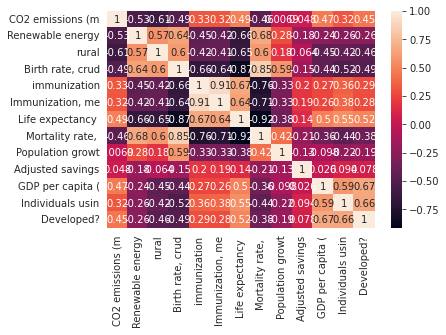

In [206]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [208]:
# we are isolating the histogram data for just rural columns so, we can graoh it for both developed and 
#un-developed countries using the histogram
hist_df = full_df
hist_df = hist_df.drop(columns = ['Country-Year', 'CODE', 'CO2 emissions (metric tons per capita)', 'Renewable energy consumption (% of total final energy consumption)', 'Birth rate, crude (per 1,000 people)', 'immunization',
                                  'Immunization, measles (% of children ages 12-23 months)', 'Life expectancy at birth, total (years)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Adjusted savings: education expenditure (% of GNI)', 'GDP per capita (current US$)',
                                  'Individuals using the Internet (% of population)', 'Country', 'Year'])
hist_df

,rural,Developed?
0,81.003,0
1,80.353,0
2,79.686,0
3,79.002,0
4,78.912,0
...,...,...
6750,67.615,0
6751,67.704,0
6752,67.763,0
6753,67.791,0


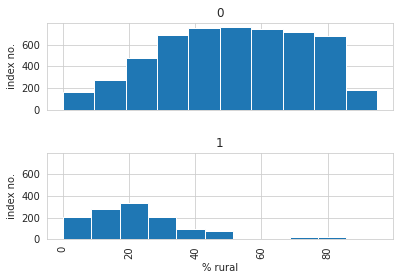

In [209]:
# we create two histograms with the numebr of countries and years aggregated on the y-axis which 
#is labelled index no. and the percentage of a country that is rural in the y axis
dev_hist = hist_df['rural'].hist(by=hist_df['Developed?'], sharex=True, sharey=True, layout = (2, 1))
for ax in dev_hist.flatten():
    ax.set_xlabel("% rural")
    ax.set_ylabel("index no.")

As we see in this plot, the 0 histogram representing undeveloped countries has much higher percentage of rural poulation between 40 to 80 percent, compared to a relative tiny population of rural population in the developed histogram, apart from the small minority with rural population of around 80%, which may represent a smaller country who is developed but its inhabitants are categorized as "rural."

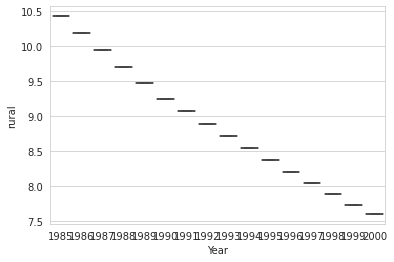

In [210]:
# this is just for fun - extrapolation
box_whisker_df = full_df
box_whisker_df = box_whisker_df[box_whisker_df['Country'] == 'Iceland']
box_whisker_df = box_whisker_df[(box_whisker_df['Year'] >= 1985) & (box_whisker_df['Year'] <= 2000)]
sns.set_style("whitegrid")
sns.boxplot(x = 'Year', y = 'rural', data = box_whisker_df)

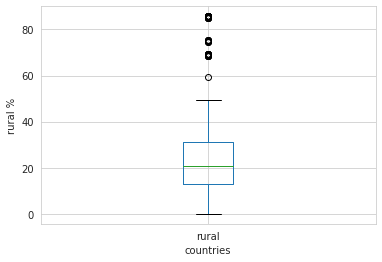

In [211]:
# this is tehe box and whisker plot for developed countries as we isolated all rows with developed values of 1 
# we clearly have a few outliers but for the most part the rural population is pretty low as we also observed in the histogram
box_whisker_df = hist_df
box_whiskerdev_df = box_whisker_df[box_whisker_df['Developed?'] == 1]
box_whiskerdev_df.reset_index()
box_whiskerdev_df['rural'].describe()
boxplot = box_whiskerdev_df.boxplot(column=['rural'])
boxplot.plot()
boxplot.set_ylabel('rural %')
boxplot.set_xlabel('countries')
plt.show()


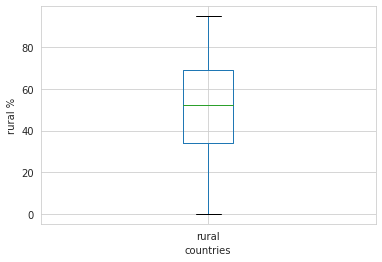

In [212]:
# this is the box and whisker plot for undeveloped countries. With less outliers, we can see overall more % of people live in rural areas in developed countries
# we isolated all the rows with developed values of 0.
box_whiskerundev_df = box_whisker_df[box_whisker_df['Developed?'] == 0]
box_whiskerundev_df.reset_index()
box_whiskerundev_df['rural'].describe()
boxplot = box_whiskerundev_df.boxplot(column=['rural'])
boxplot.plot()
boxplot.set_ylabel('rural %')
boxplot.set_xlabel('countries')
plt.show()

### Part 3: Modeling Indicator Data to Predict Country Development

We will now train and test our development index for the countries and years using the indicators data we cleaned in step 1 and create a neural net to create a model see how great an approximation our model at predicting development was. If we receive a high enough accuracy (90%+) we can continue.

In [213]:
dataset = combined_df.values
X = dataset[:,0:12]
Y = dataset[:,12]
X

array([[2.93957031e-01, 9.82009875e+01, 8.10030000e+01, ...,
        1.73337532e+00, 2.43348702e+02, 0.00000000e+00],
       [2.67771950e-01, 9.82009875e+01, 8.03530000e+01, ...,
        1.77783377e+00, 5.52721592e+02, 0.00000000e+00],
       [2.69229503e-01, 9.80311531e+01, 7.96860000e+01, ...,
        1.82229221e+00, 2.06061674e+02, 3.29084000e-04],
       ...,
       [7.18570496e-01, 8.34929962e+01, 6.77630000e+01, ...,
        1.91000000e+00, 1.33566506e+03, 2.44000000e+01],
       [8.49792905e-01, 8.13636017e+01, 6.77910000e+01, ...,
        1.91000000e+00, 1.35216265e+03, 2.50000000e+01],
       [3.86759996e-01, 7.00953979e+01, 6.77900000e+01, ...,
        1.91000000e+00, 1.15615486e+03, 2.51000000e+01]])

In [214]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[6.16262970e-03, 9.98556930e-01, 8.53175063e-01, ...,
        2.11247373e-02, 1.15782153e-03, 0.00000000e+00],
       [5.61367546e-03, 9.98556930e-01, 8.46328850e-01, ...,
        2.17799551e-02, 2.78191195e-03, 0.00000000e+00],
       [5.64423218e-03, 9.96829969e-01, 8.39303582e-01, ...,
        2.24351728e-02, 9.62078768e-04, 3.30069281e-06],
       ...,
       [1.50643918e-02, 8.48998693e-01, 7.13722971e-01, ...,
        2.37277889e-02, 6.89206845e-03, 2.44730539e-01],
       [1.78153895e-02, 8.27345940e-01, 7.14017884e-01, ...,
        2.37277889e-02, 6.97867453e-03, 2.50748503e-01],
       [8.10818721e-03, 7.12765189e-01, 7.14007352e-01, ...,
        2.37277889e-02, 5.94970793e-03, 2.51751497e-01]])

In [270]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(4679, 12) (1003, 12) (1003, 12) (4679,) (1003,) (1003,)


We first train a simple Logisic Regression on our completely cleaned dataset. After training the data and fitting it on a train set, we see that we have an accuarcny of 0.94 on the test set. 

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
logistic_pred = logistic.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(Y_test, logistic_pred))

Accuracy:  0.9401794616151545


We then create a neural net to hopefully find a more accurate method to fit the data. We have three Dense layers in this Keras Neural Net which we process and train below. We use the relu activation parameter on the first two layers and the sigmoid parameter on the last one.

In [272]:

model = Sequential([
    Dense(32, activation='relu', input_shape=(12,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [273]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [274]:
hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
147/147 [==============================] - 1s 3ms/step - loss: 0.5202 - accuracy: 0.8012 - val_loss: 0.4438 - val_accuracy: 0.8215
Epoch 2/100
147/147 [==============================] - 0s 2ms/step - loss: 0.4177 - accuracy: 0.8222 - val_loss: 0.3871 - val_accuracy: 0.8215
Epoch 3/100
147/147 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8222 - val_loss: 0.3412 - val_accuracy: 0.8215
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 0.3285 - accuracy: 0.8250 - val_loss: 0.3022 - val_accuracy: 0.8514
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8615 - val_loss: 0.2682 - val_accuracy: 0.8923
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.8895 - val_loss: 0.2393 - val_accuracy: 0.9182
Epoch 7/100
147/147 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.9047 - val_loss: 0.2178 - val_accuracy: 0.9212

In [275]:
model.evaluate(X_test, Y_test)[1]

32/32 [==============================] - 0s 1ms/step - loss: 0.1370 - accuracy: 0.9501


0.9501495361328125

Our accuracy for the neural net is above the observed accuracy for the Logistic Regression, and therefore we will use this neural net to predict future values. We show plots of the accuracy and loss variables as we trained the 100 epochs above. Now we go and generate future values for our indicators from years 2020 to 2030. 

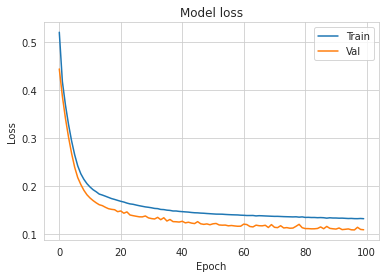

In [329]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

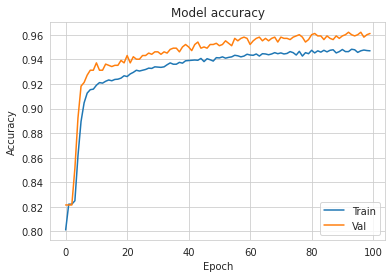

In [330]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [331]:
India_df = full_df[full_df['Country'] == 'India']
India_rural = India_df[['Year', 'rural']].reset_index()
India_rural = India_rural.drop(columns= {'index'})
NaN = np.nan
India_rural.loc[len(India_rural.index)] = [2020, 0]
India_rural.loc[len(India_rural.index)] = [2021, 0]
India_rural.loc[len(India_rural.index)] = [2022, 0]
India_rural.loc[len(India_rural.index)] = [2023, 0]
India_rural.loc[len(India_rural.index)] = [2024, 0]
India_rural.loc[len(India_rural.index)] = [2025, 0]
India_rural.loc[len(India_rural.index)] = [2026, 0]
India_rural.loc[len(India_rural.index)] = [2027, 0]
India_rural.loc[len(India_rural.index)] = [2028, 0]
India_rural.loc[len(India_rural.index)] = [2029, 0]
India_rural.loc[len(India_rural.index)] = [2030, 0]
India_rural['Year'] = pd.to_datetime(India_rural['Year'], format='%Y')
India_rural = India_rural.set_index('Year')
India_rural


,rural
Year,
1985-01-01,75.652
1986-01-01,75.415
1987-01-01,75.177
1988-01-01,74.937
1989-01-01,74.695
1990-01-01,74.453
1991-01-01,74.222
1992-01-01,74.016
1993-01-01,73.809


In [ ]:
#In the next several sells, we will explore different methods of forecast our data from 2020-2030. We find that Holt-Linear, Holt-Winter, and ARIMA are teh most efficent methods of doing this. 

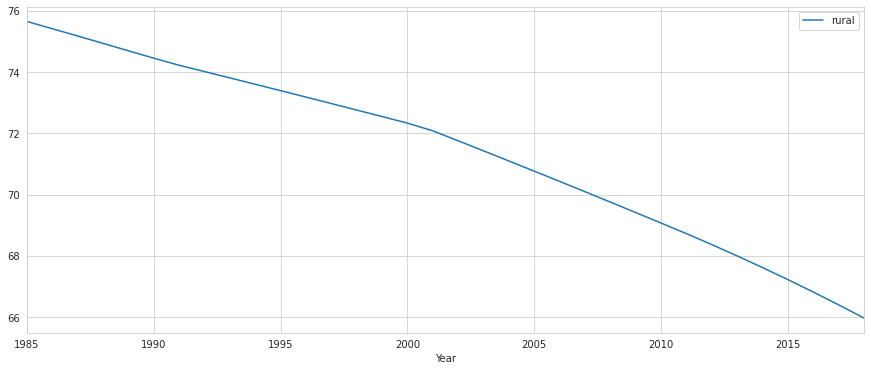

In [332]:
India_rural.head(34).plot(figsize=(15, 6))
plt.show()

In [333]:
India_rural
lst = list(range(0,46))
arr = np.array(lst)
India_rural['years_from_start'] = arr
India_rural

,rural,years_from_start
Year,,
1985-01-01,75.652,0
1986-01-01,75.415,1
1987-01-01,75.177,2
1988-01-01,74.937,3
1989-01-01,74.695,4
1990-01-01,74.453,5
1991-01-01,74.222,6
1992-01-01,74.016,7
1993-01-01,73.809,8


In [334]:
x = India_rural['years_from_start'].values.reshape(-1, 1)
y = India_rural['rural'].values

In [335]:
# linear_model = linear_model.LinearRegression().fit(x, y)
# linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
# LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
# linear_model.predict([[1]])

In [336]:
train=India_rural[0:35] 
test=India_rural[34:]

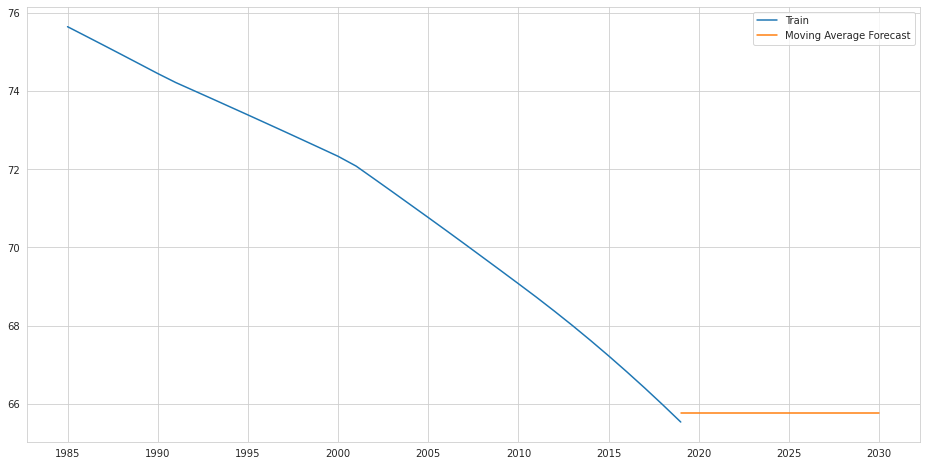

In [337]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['rural'].rolling(2).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['rural'], label='Train')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [338]:
rms = sqrt(mean_squared_error(test.rural, y_hat_avg.moving_avg_forecast))
print(rms)

62.9499072358332


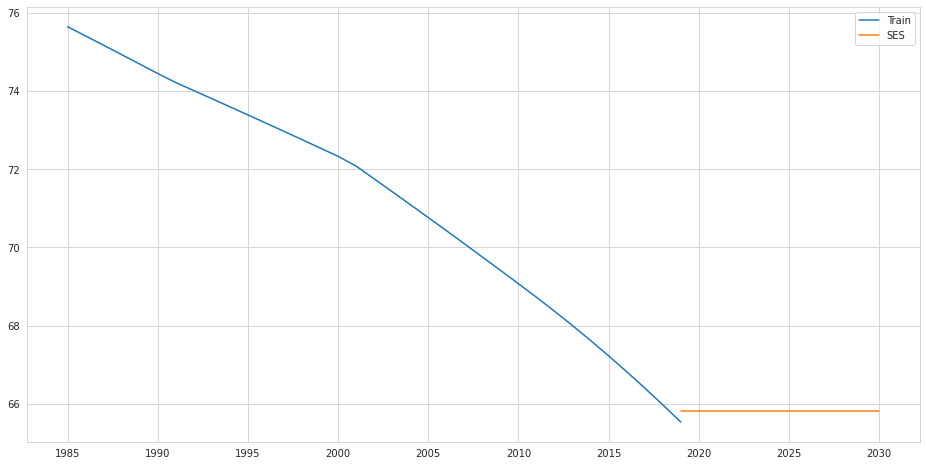

In [339]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['rural'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['rural'], label='Train')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [340]:
rms = sqrt(mean_squared_error(test.rural, y_hat_avg.SES))
print(rms)

63.01531725684915


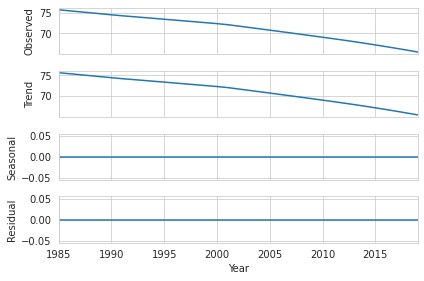

In [341]:
sm.tsa.seasonal_decompose(train.rural).plot()
result = sm.tsa.stattools.adfuller(train.rural)
plt.show()

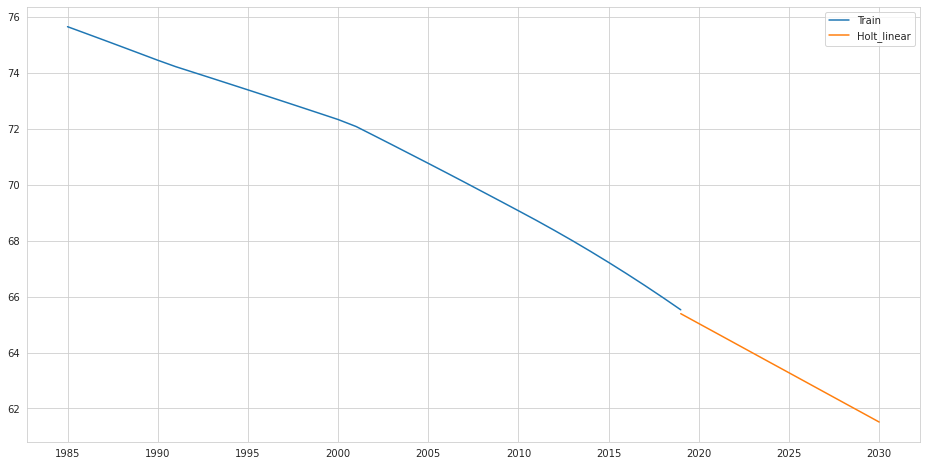

In [342]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['rural'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['rural'], label='Train')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [343]:
rms = sqrt(mean_squared_error(test.rural, y_hat_avg.Holt_linear))
print(rms)

60.59145988274672


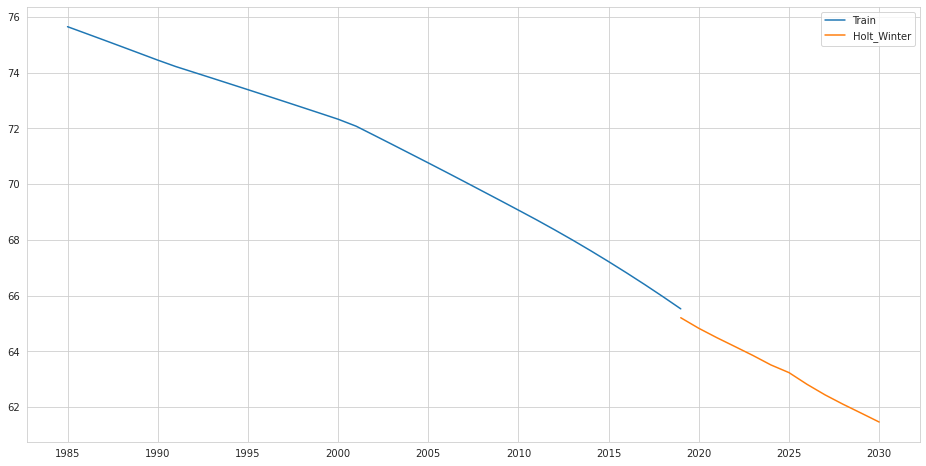

In [344]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['rural']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['rural'], label='Train')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [345]:
rms = sqrt(mean_squared_error(test.rural, y_hat_avg.Holt_Winter))
print(rms)

60.47753606722867


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


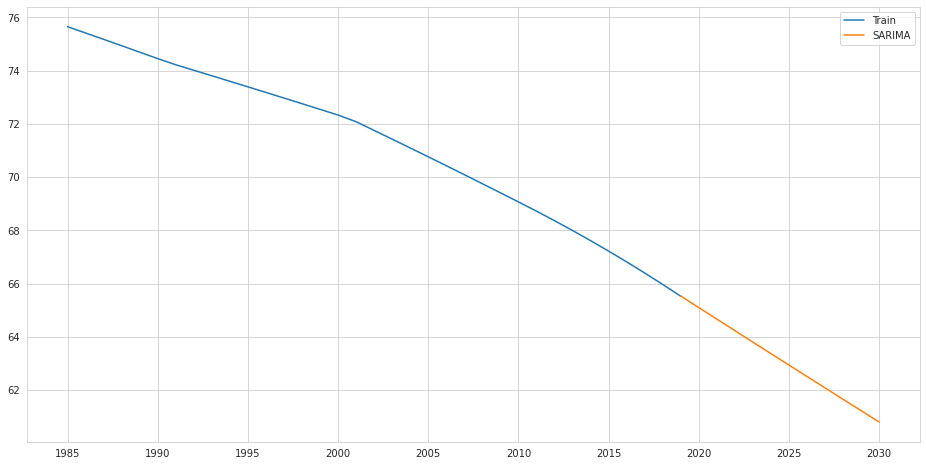

Year
2019-01-01    65.536475
2020-01-01    65.102168
2021-01-01    64.668758
2022-01-01    64.235834
2023-01-01    63.804021
2024-01-01    63.372747
2025-01-01    62.942529
2026-01-01    62.512894
2027-01-01    62.084270
2028-01-01    61.656265
2029-01-01    61.229232
2030-01-01    60.802847
Name: SARIMA, dtype: float64

In [346]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.rural, order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2019-01-01", end="2030-01-01", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train['rural'], label='Train')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
y_hat_avg['SARIMA']

In [347]:
rms = sqrt(mean_squared_error(test.rural, y_hat_avg.SARIMA))
print(rms)

60.28074715734833


In [348]:
y_hat_avg = y_hat_avg.iloc[1: , :]
y_hat_avg = y_hat_avg.drop(columns={'rural'})
y_hat_avg = y_hat_avg.rename(columns={'SARIMA': 'rural'})
y_hat_avg['years_from_start'] = y_hat_avg['years_from_start'] + 1985
y_hat_avg = y_hat_avg.reset_index()
y_hat_avg = y_hat_avg.drop(columns={'Year'})
y_hat_avg = y_hat_avg.rename(columns={'years_from_start': 'Year'})
y_hat_avg


#new_df = pd.concat([India_rural, y_hat_avg], axis=0)
#new_df

,Year,rural
0,2020,65.102168
1,2021,64.668758
2,2022,64.235834
3,2023,63.804021
4,2024,63.372747
5,2025,62.942529
6,2026,62.512894
7,2027,62.084270
8,2028,61.656265
9,2029,61.229232


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


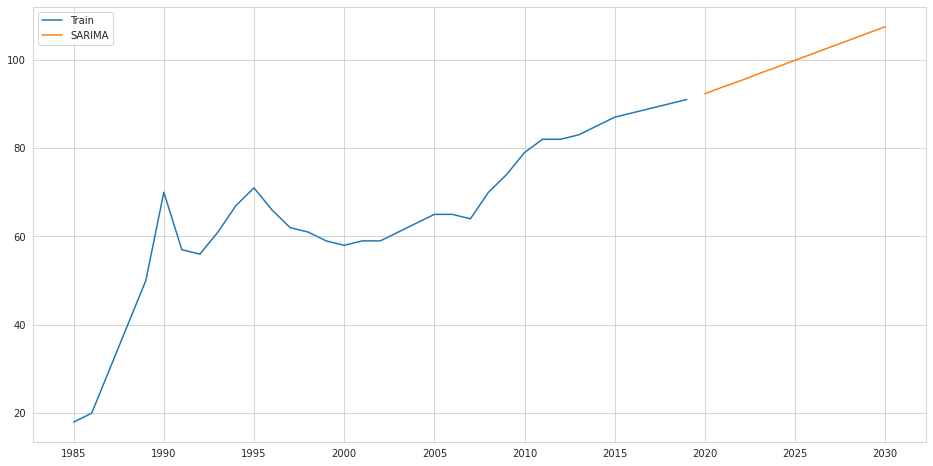

,Year,immunization
0,2020,92.299437
1,2021,93.847947
2,2022,95.285545
3,2023,96.866785
4,2024,98.342501
5,2025,99.895390
6,2026,101.391492
7,2027,102.929029
8,2028,104.435984
9,2029,105.965162


In [349]:
India_df = full_df[full_df['Country'] == 'India']
India_immunization = India_df[['Year', 'immunization']].reset_index()
India_immunization = India_immunization.drop(columns= {'index'})
NaN = np.nan
India_immunization.loc[len(India_immunization.index)] = [2020, 0]
India_immunization.loc[len(India_immunization.index)] = [2021, 0]
India_immunization.loc[len(India_immunization.index)] = [2022, 0]
India_immunization.loc[len(India_immunization.index)] = [2023, 0]
India_immunization.loc[len(India_immunization.index)] = [2024, 0]
India_immunization.loc[len(India_immunization.index)] = [2025, 0]
India_immunization.loc[len(India_immunization.index)] = [2026, 0]
India_immunization.loc[len(India_immunization.index)] = [2027, 0]
India_immunization.loc[len(India_immunization.index)] = [2028, 0]
India_immunization.loc[len(India_immunization.index)] = [2029, 0]
India_immunization.loc[len(India_immunization.index)] = [2030, 0]
India_immunization['Year'] = pd.to_datetime(India_immunization['Year'], format='%Y')
India_immunization = India_immunization.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_immunization['years_from_start'] = arr
x = India_immunization['years_from_start'].values.reshape(-1, 1)
y = India_immunization['immunization'].values
train=India_immunization[0:35] 
test=India_immunization[34:]

dd= np.asarray(train.immunization)

y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.immunization, order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2020-01-01", end="2030-01-01", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['immunization'], label='Train')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
y_hat_avg['SARIMA']

y_hat_avg = y_hat_avg.iloc[1: , :]
y_hat_avg = y_hat_avg.drop(columns={'immunization'})
y_hat_avg = y_hat_avg.rename(columns={'SARIMA': 'immunization'})
y_hat_avg['years_from_start'] = y_hat_avg['years_from_start'] + 1985
y_hat_avg = y_hat_avg.reset_index()
y_hat_avg = y_hat_avg.drop(columns={'Year'})
y_hat_avg = y_hat_avg.rename(columns={'years_from_start': 'Year'})
y_hat_avg

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


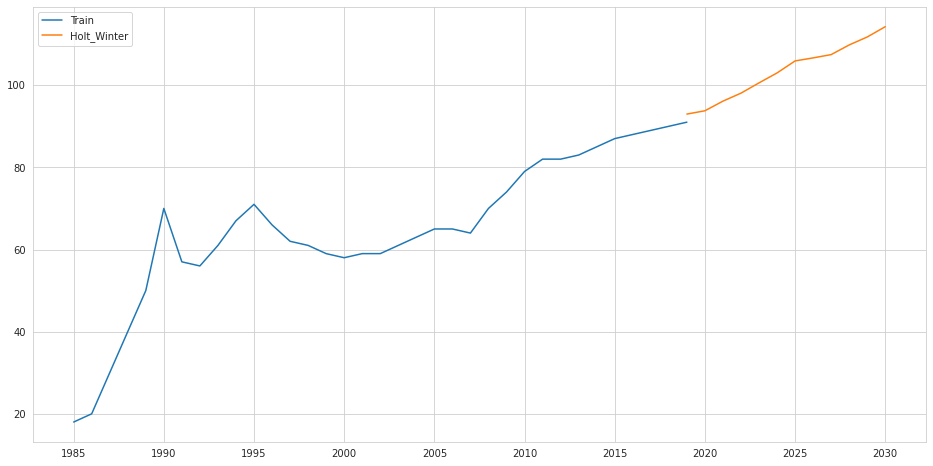

,Year,immunization
0,2020,93.774419
1,2021,96.123593
2,2022,98.066214
3,2023,100.567507
4,2024,102.985490
5,2025,105.912300
6,2026,106.648076
7,2027,107.452828
8,2028,109.802002
9,2029,111.744623


In [350]:
India_df = full_df[full_df['Country'] == 'India']
India_immunization = India_df[['Year', 'immunization']].reset_index()
India_immunization = India_immunization.drop(columns= {'index'})
NaN = np.nan
India_immunization.loc[len(India_immunization.index)] = [2020, 0]
India_immunization.loc[len(India_immunization.index)] = [2021, 0]
India_immunization.loc[len(India_immunization.index)] = [2022, 0]
India_immunization.loc[len(India_immunization.index)] = [2023, 0]
India_immunization.loc[len(India_immunization.index)] = [2024, 0]
India_immunization.loc[len(India_immunization.index)] = [2025, 0]
India_immunization.loc[len(India_immunization.index)] = [2026, 0]
India_immunization.loc[len(India_immunization.index)] = [2027, 0]
India_immunization.loc[len(India_immunization.index)] = [2028, 0]
India_immunization.loc[len(India_immunization.index)] = [2029, 0]
India_immunization.loc[len(India_immunization.index)] = [2030, 0]
India_immunization['Year'] = pd.to_datetime(India_immunization['Year'], format='%Y')
India_immunization = India_immunization.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_immunization['years_from_start'] = arr
x = India_immunization['years_from_start'].values.reshape(-1, 1)
y = India_immunization['immunization'].values
train=India_immunization[0:35] 
test=India_immunization[34:]

dd= np.asarray(train.immunization)

y_hat_avg_immunization = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['immunization']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg_immunization['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['immunization'], label='Train')
plt.plot(y_hat_avg_immunization['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
y_hat_avg_immunization['Holt_Winter']

y_hat_avg_immunization = y_hat_avg_immunization.iloc[1: , :]
y_hat_avg_immunization = y_hat_avg_immunization.drop(columns={'immunization'})
y_hat_avg_immunization = y_hat_avg_immunization.rename(columns={'Holt_Winter': 'immunization'})
y_hat_avg_immunization['years_from_start'] = y_hat_avg_immunization['years_from_start'] + 1985
y_hat_avg_immunization = y_hat_avg_immunization.reset_index()
y_hat_avg_immunization = y_hat_avg_immunization.drop(columns={'Year'})
y_hat_avg_immunization = y_hat_avg_immunization.rename(columns={'years_from_start': 'Year'})
y_hat_avg_immunization

#new_df = pd.concat([India_immunization, y_hat_avg], axis=0)
#new_df

Here we first run a Linear Regression to see if it can accurately map our train data to the test data we already have. We clearly observe for most countries this model will not be adequate (very high RMSE) to plot our data. We then use more accurate and complex methods such as Exponentual Smoothing, Holt Linear, Holt Winter and SARIMA which are all proven models to fit time series data. We will calculate the RSME values of each regression and then only use the smallest to actually calculate the future data points we need per indicator (data from 2020 to 2030), which we do in the next step!

Rural Data Forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

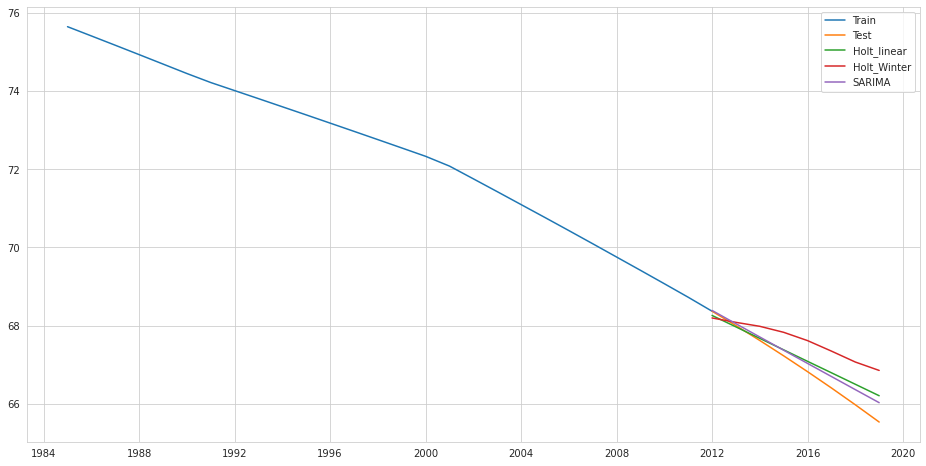

Holt Linear RMSE: 0.351679888391797 Holt Winter RMSE 0.7904961713693037 ARIMA RMSE: 0.2640236024402293


In [351]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_rural = India_df[['Year', 'rural']].reset_index()
India_rural = India_rural.drop(columns= {'index'})
India_rural = India_rural.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_rural['years_from_start'] = arr
x = India_rural['years_from_start'].values.reshape(-1, 1)
y = India_rural['rural'].values
train=India_rural[0:28] 
test=India_rural[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['rural'], label='Train')
plt.plot(test['rural'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['rural'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test.rural, y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['rural']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test.rural, y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train.rural, order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test.rural, y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


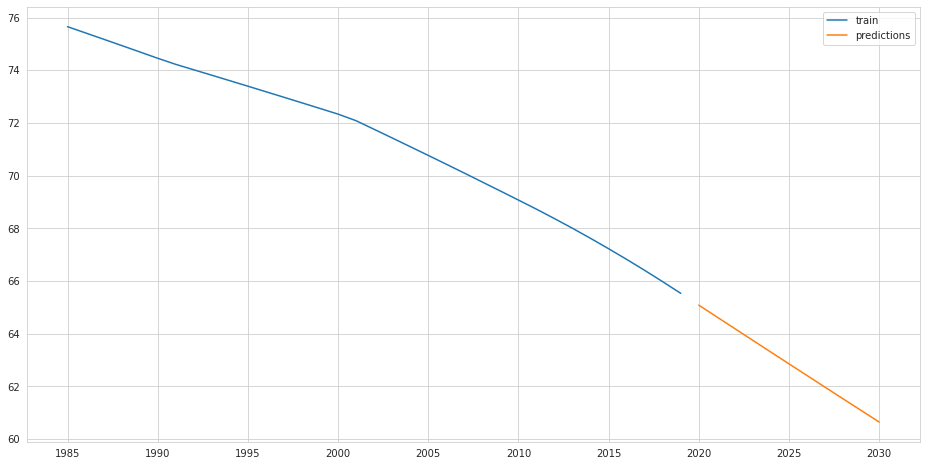

,Year,rural
0,2020,65.081139
1,2021,64.633910
2,2022,64.187055
3,2023,63.741128
4,2024,63.295956
5,2025,62.851694
6,2026,62.408199
7,2027,61.965597
8,2028,61.523770
9,2029,61.082824


In [352]:
India_df = full_df[full_df['Country'] == 'India']
India_rural = India_df[['Year', 'rural']].reset_index()
India_rural = India_rural.drop(columns= {'index'})
NaN = np.nan
India_rural.loc[len(India_rural.index)] = [2020, 0]
India_rural.loc[len(India_rural.index)] = [2021, 0]
India_rural.loc[len(India_rural.index)] = [2022, 0]
India_rural.loc[len(India_rural.index)] = [2023, 0]
India_rural.loc[len(India_rural.index)] = [2024, 0]
India_rural.loc[len(India_rural.index)] = [2025, 0]
India_rural.loc[len(India_rural.index)] = [2026, 0]
India_rural.loc[len(India_rural.index)] = [2027, 0]
India_rural.loc[len(India_rural.index)] = [2028, 0]
India_rural.loc[len(India_rural.index)] = [2029, 0]
India_rural.loc[len(India_rural.index)] = [2030, 0]
India_rural['Year'] = pd.to_datetime(India_rural['Year'], format='%Y')
India_rural = India_rural.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_rural['years_from_start'] = arr
x = India_rural['years_from_start'].values.reshape(-1, 1)
y = India_rural['rural'].values
train=India_rural[0:35] 
test=India_rural[34:]

dd= np.asarray(train.rural)

y_hat_avg_rural = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train.rural, order=(2, 1, 4)).fit()
y_hat_avg_rural['SARIMA'] = fit_arima.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['rural'], label='train')
plt.plot(y_hat_avg_rural['SARIMA'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_rural['SARIMA']

y_hat_avg_rural = y_hat_avg_rural.iloc[1: , :]
y_hat_avg_rural = y_hat_avg_rural.drop(columns={'rural'})
y_hat_avg_rural = y_hat_avg_rural.rename(columns={'SARIMA': 'rural'})
y_hat_avg_rural['years_from_start'] = y_hat_avg_rural['years_from_start'] + 1985
y_hat_avg_rural = y_hat_avg_rural.reset_index()
y_hat_avg_rural = y_hat_avg_rural.drop(columns={'Year'})
y_hat_avg_rural = y_hat_avg_rural.rename(columns={'years_from_start': 'Year'})
y_hat_avg_rural

CO2 emissions (metric tons per capita) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-p

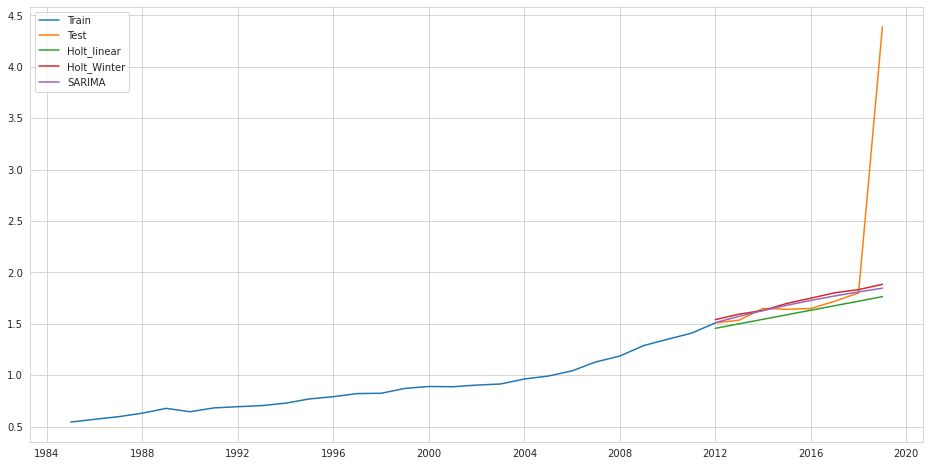

Holt Linear RMSE: 0.9304384447238642 Holt Winter RMSE 0.8880172292290017 ARIMA RMSE: 0.900382708611217


In [353]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_c02 = India_df[['Year', 'CO2 emissions (metric tons per capita)']].reset_index()
India_c02 = India_c02.drop(columns= {'index'})
India_c02 = India_c02.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_c02['years_from_start'] = arr
x = India_c02['years_from_start'].values.reshape(-1, 1)
y = India_c02['CO2 emissions (metric tons per capita)'].values
train=India_c02[0:28] 
test=India_c02[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['CO2 emissions (metric tons per capita)'], label='Train')
plt.plot(test['CO2 emissions (metric tons per capita)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['CO2 emissions (metric tons per capita)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['CO2 emissions (metric tons per capita)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['CO2 emissions (metric tons per capita)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['CO2 emissions (metric tons per capita)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['CO2 emissions (metric tons per capita)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['CO2 emissions (metric tons per capita)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


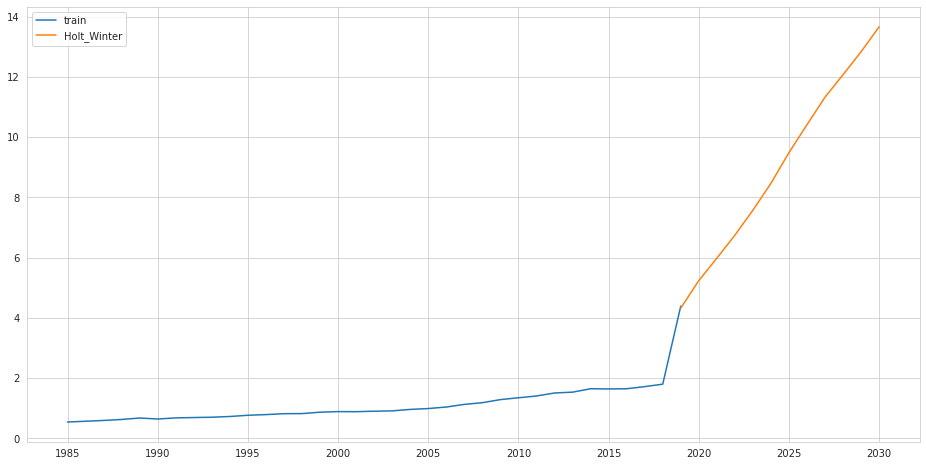

,Year,CO2 emissions (metric tons per capita)
0,2020,5.235471
1,2021,5.980879
2,2022,6.744815
3,2023,7.573741
4,2024,8.464568
5,2025,9.487515
6,2026,10.412682
7,2027,11.325442
8,2028,12.070850
9,2029,12.834786


In [354]:
India_df = full_df[full_df['Country'] == 'India']
India_c02 = India_df[['Year', 'CO2 emissions (metric tons per capita)']].reset_index()
India_c02 = India_c02.drop(columns= {'index'})
NaN = np.nan
India_c02.loc[len(India_c02.index)] = [2020, 0]
India_c02.loc[len(India_c02.index)] = [2021, 0]
India_c02.loc[len(India_c02.index)] = [2022, 0]
India_c02.loc[len(India_c02.index)] = [2023, 0]
India_c02.loc[len(India_c02.index)] = [2024, 0]
India_c02.loc[len(India_c02.index)] = [2025, 0]
India_c02.loc[len(India_c02.index)] = [2026, 0]
India_c02.loc[len(India_c02.index)] = [2027, 0]
India_c02.loc[len(India_c02.index)] = [2028, 0]
India_c02.loc[len(India_c02.index)] = [2029, 0]
India_c02.loc[len(India_c02.index)] = [2030, 0]
India_c02['Year'] = pd.to_datetime(India_c02['Year'], format='%Y')
India_c02 = India_c02.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_c02['years_from_start'] = arr
x = India_c02['years_from_start'].values.reshape(-1, 1)
y = India_c02['CO2 emissions (metric tons per capita)'].values
train=India_c02[0:35] 
test=India_c02[34:]

dd= np.asarray(train['CO2 emissions (metric tons per capita)'])

y_hat_avg_c02 = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['CO2 emissions (metric tons per capita)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg_c02['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['CO2 emissions (metric tons per capita)'], label='train')
plt.plot(y_hat_avg_c02['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
y_hat_avg_c02['Holt_Winter']



y_hat_avg_c02 = y_hat_avg_c02.iloc[1: , :]
y_hat_avg_c02 = y_hat_avg_c02.drop(columns={'CO2 emissions (metric tons per capita)'})
y_hat_avg_c02 = y_hat_avg_c02.rename(columns={'Holt_Winter': 'CO2 emissions (metric tons per capita)'})
y_hat_avg_c02['years_from_start'] = y_hat_avg_c02['years_from_start'] + 1985
y_hat_avg_c02 = y_hat_avg_c02.reset_index()
y_hat_avg_c02 = y_hat_avg_c02.drop(columns={'Year'})
y_hat_avg_c02 = y_hat_avg_c02.rename(columns={'years_from_start': 'Year'})
y_hat_avg_c02


Renewable energy consumption (% of total final energy consumption) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


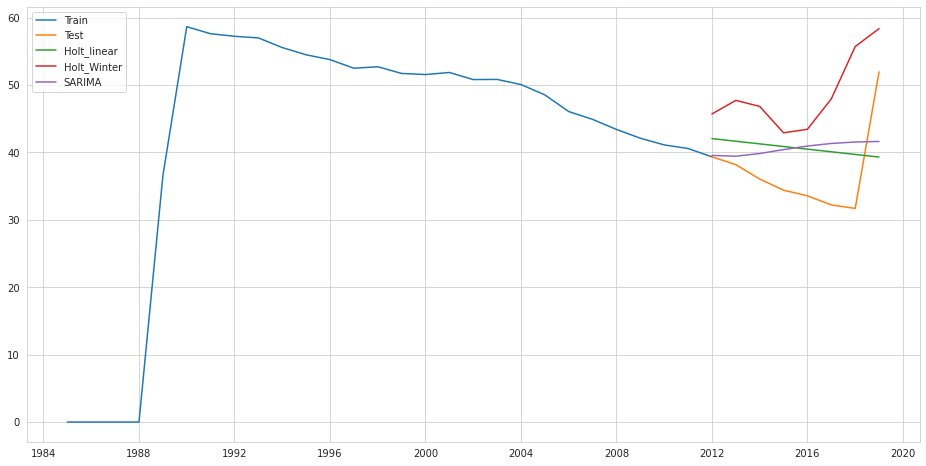

Holt Linear RMSE: 7.2681617174066595 Holt Winter RMSE 12.662067336845604 ARIMA RMSE: 7.0144648775482485


In [355]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_energy = India_df[['Year', 'Renewable energy consumption (% of total final energy consumption)']].reset_index()
India_energy = India_energy.drop(columns= {'index'})
India_energy = India_energy.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_energy['years_from_start'] = arr
x = India_energy['years_from_start'].values.reshape(-1, 1)
y = India_energy['Renewable energy consumption (% of total final energy consumption)'].values
train=India_energy[0:28] 
test=India_energy[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Renewable energy consumption (% of total final energy consumption)'], label='Train')
plt.plot(test['Renewable energy consumption (% of total final energy consumption)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Renewable energy consumption (% of total final energy consumption)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Renewable energy consumption (% of total final energy consumption)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Renewable energy consumption (% of total final energy consumption)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Renewable energy consumption (% of total final energy consumption)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Renewable energy consumption (% of total final energy consumption)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Renewable energy consumption (% of total final energy consumption)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


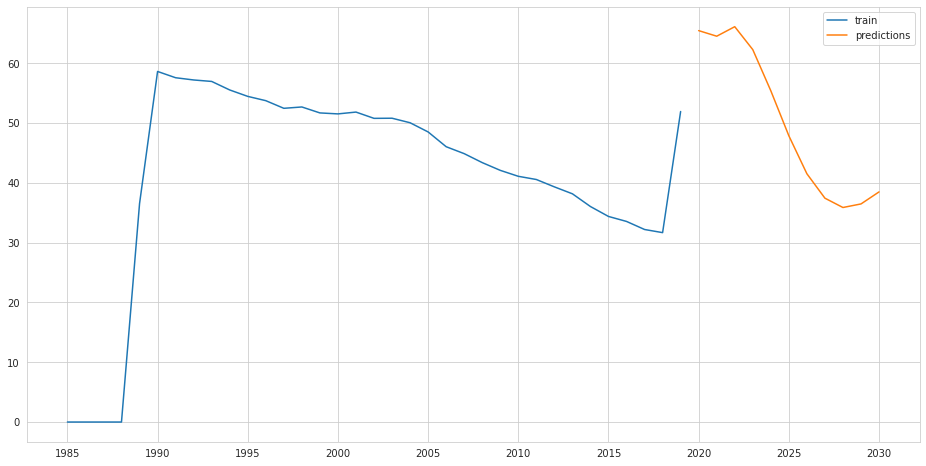

,Year,Renewable energy consumption (% of total final energy consumption)
0,2020,65.487840
1,2021,64.551770
2,2022,66.144590
3,2023,62.308872
4,2024,55.428133
5,2025,47.885929
6,2026,41.538364
7,2027,37.452440
8,2028,35.893007
9,2029,36.490925


In [356]:
India_df = full_df[full_df['Country'] == 'India']
India_energy = India_df[['Year', 'Renewable energy consumption (% of total final energy consumption)']].reset_index()
India_energy = India_energy.drop(columns= {'index'})
NaN = np.nan
India_energy.loc[len(India_energy.index)] = [2020, 0]
India_energy.loc[len(India_energy.index)] = [2021, 0]
India_energy.loc[len(India_energy.index)] = [2022, 0]
India_energy.loc[len(India_energy.index)] = [2023, 0]
India_energy.loc[len(India_energy.index)] = [2024, 0]
India_energy.loc[len(India_energy.index)] = [2025, 0]
India_energy.loc[len(India_energy.index)] = [2026, 0]
India_energy.loc[len(India_energy.index)] = [2027, 0]
India_energy.loc[len(India_energy.index)] = [2028, 0]
India_energy.loc[len(India_energy.index)] = [2029, 0]
India_energy.loc[len(India_energy.index)] = [2030, 0]
India_energy['Year'] = pd.to_datetime(India_energy['Year'], format='%Y')
India_energy = India_energy.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_energy['years_from_start'] = arr
x = India_energy['years_from_start'].values.reshape(-1, 1)
y = India_energy['Renewable energy consumption (% of total final energy consumption)'].values
train=India_energy[0:35] 
test=India_energy[34:]

dd= np.asarray(train['Renewable energy consumption (% of total final energy consumption)'])

y_hat_avg_energy = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Renewable energy consumption (% of total final energy consumption)'], order=(2, 1, 4)).fit()
y_hat_avg_energy['SARIMA'] = fit_arima.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Renewable energy consumption (% of total final energy consumption)'], label='train')
plt.plot(y_hat_avg_energy['SARIMA'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_energy['SARIMA']

y_hat_avg_energy = y_hat_avg_energy.iloc[1: , :]
y_hat_avg_energy = y_hat_avg_energy.drop(columns={'Renewable energy consumption (% of total final energy consumption)'})
y_hat_avg_energy = y_hat_avg_energy.rename(columns={'SARIMA': 'Renewable energy consumption (% of total final energy consumption)'})
y_hat_avg_energy['years_from_start'] = y_hat_avg_energy['years_from_start'] + 1985
y_hat_avg_energy = y_hat_avg_energy.reset_index()
y_hat_avg_energy = y_hat_avg_energy.drop(columns={'Year'})
y_hat_avg_energy = y_hat_avg_energy.rename(columns={'years_from_start': 'Year'})
y_hat_avg_energy

Birth rate, crude (per 1,000 people) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


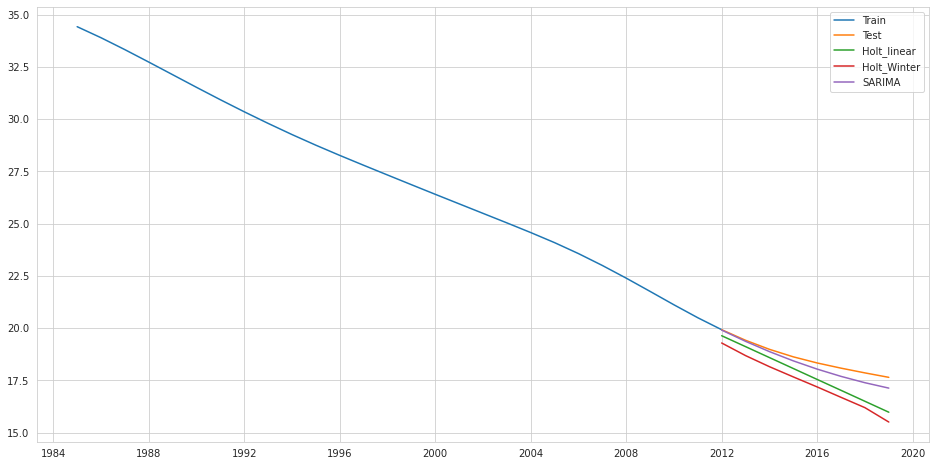

Holt Linear RMSE: 0.9366054598483726 Holt Winter RMSE 1.2821574890010523 ARIMA RMSE: 0.3121577428690886


In [357]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_birth = India_df[['Year', 'Birth rate, crude (per 1,000 people)']].reset_index()
India_birth = India_birth.drop(columns= {'index'})
India_birth = India_birth.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_birth['years_from_start'] = arr
x = India_birth['years_from_start'].values.reshape(-1, 1)
y = India_birth['Birth rate, crude (per 1,000 people)'].values
train=India_birth[0:28] 
test=India_birth[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Birth rate, crude (per 1,000 people)'], label='Train')
plt.plot(test['Birth rate, crude (per 1,000 people)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Birth rate, crude (per 1,000 people)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Birth rate, crude (per 1,000 people)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Birth rate, crude (per 1,000 people)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Birth rate, crude (per 1,000 people)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Birth rate, crude (per 1,000 people)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Birth rate, crude (per 1,000 people)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


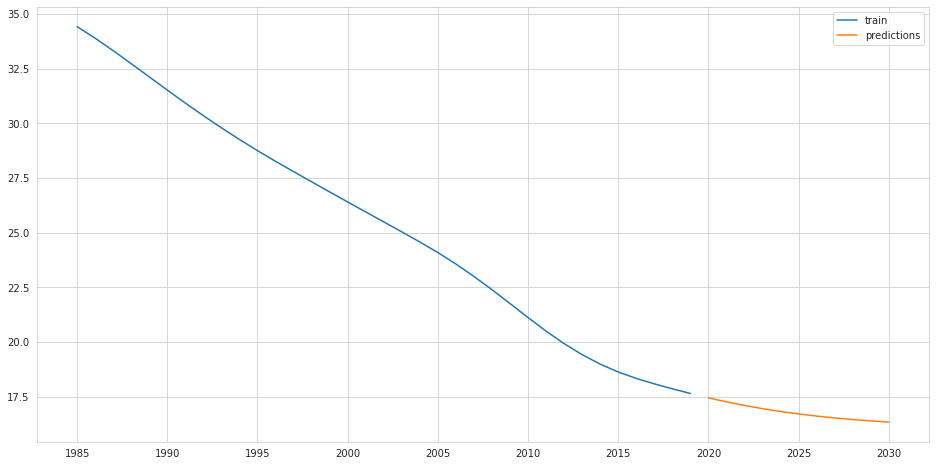

,Year,"Birth rate, crude (per 1,000 people)"
0,2020,17.443252
1,2021,17.259194
2,2022,17.094408
3,2023,16.948325
4,2024,16.819593
5,2025,16.706848
6,2026,16.608734
7,2027,16.523931
8,2028,16.451160
9,2029,16.389204


In [358]:
India_df = full_df[full_df['Country'] == 'India']
India_birth = India_df[['Year', 'Birth rate, crude (per 1,000 people)']].reset_index()
India_birth = India_birth.drop(columns= {'index'})
NaN = np.nan
India_birth.loc[len(India_birth.index)] = [2020, 0]
India_birth.loc[len(India_birth.index)] = [2021, 0]
India_birth.loc[len(India_birth.index)] = [2022, 0]
India_birth.loc[len(India_birth.index)] = [2023, 0]
India_birth.loc[len(India_birth.index)] = [2024, 0]
India_birth.loc[len(India_birth.index)] = [2025, 0]
India_birth.loc[len(India_birth.index)] = [2026, 0]
India_birth.loc[len(India_birth.index)] = [2027, 0]
India_birth.loc[len(India_birth.index)] = [2028, 0]
India_birth.loc[len(India_birth.index)] = [2029, 0]
India_birth.loc[len(India_birth.index)] = [2030, 0]
India_birth['Year'] = pd.to_datetime(India_birth['Year'], format='%Y')
India_birth = India_birth.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_birth['years_from_start'] = arr
x = India_birth['years_from_start'].values.reshape(-1, 1)
y = India_birth['Birth rate, crude (per 1,000 people)'].values
train=India_birth[0:35] 
test=India_birth[34:]

dd= np.asarray(train['Birth rate, crude (per 1,000 people)'])

y_hat_avg_birth = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Birth rate, crude (per 1,000 people)'], order=(2, 1, 4)).fit()
y_hat_avg_birth['SARIMA'] = fit_arima.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Birth rate, crude (per 1,000 people)'], label='train')
plt.plot(y_hat_avg_birth['SARIMA'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_birth['SARIMA']

y_hat_avg_birth = y_hat_avg_birth.iloc[1: , :]
y_hat_avg_birth = y_hat_avg_birth.drop(columns={'Birth rate, crude (per 1,000 people)'})
y_hat_avg_birth = y_hat_avg_birth.rename(columns={'SARIMA': 'Birth rate, crude (per 1,000 people)'})
y_hat_avg_birth['years_from_start'] = y_hat_avg_birth['years_from_start'] + 1985
y_hat_avg_birth = y_hat_avg_birth.reset_index()
y_hat_avg_birth = y_hat_avg_birth.drop(columns={'Year'})
y_hat_avg_birth = y_hat_avg_birth.rename(columns={'years_from_start': 'Year'})
y_hat_avg_birth

Immunization, measles (% of children ages 12-23 months) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


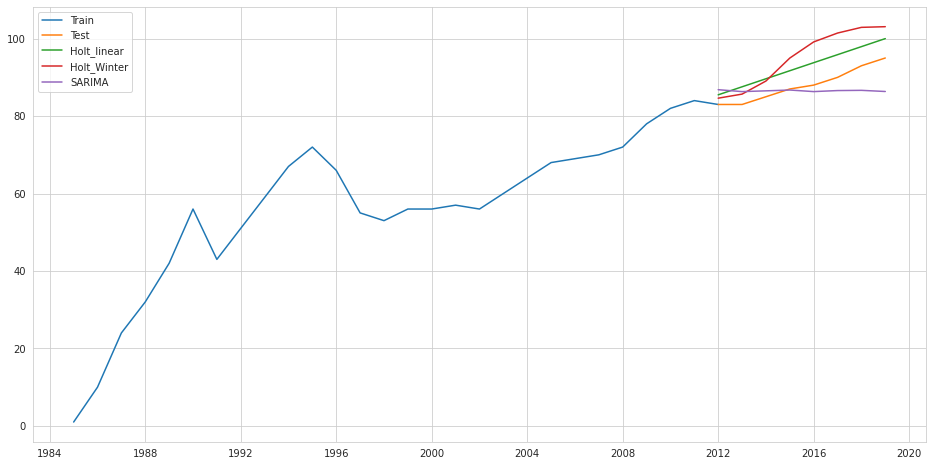

Holt Linear RMSE: 4.84965727872645 Holt Winter RMSE 7.977012756782934 ARIMA RMSE: 4.43736356083121


In [359]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_measles = India_df[['Year', 'Immunization, measles (% of children ages 12-23 months)']].reset_index()
India_measles = India_measles.drop(columns= {'index'})
India_measles = India_measles.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_measles['years_from_start'] = arr
x = India_measles['years_from_start'].values.reshape(-1, 1)
y = India_measles['Immunization, measles (% of children ages 12-23 months)'].values
train=India_measles[0:28] 
test=India_measles[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Immunization, measles (% of children ages 12-23 months)'], label='Train')
plt.plot(test['Immunization, measles (% of children ages 12-23 months)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Immunization, measles (% of children ages 12-23 months)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Immunization, measles (% of children ages 12-23 months)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Immunization, measles (% of children ages 12-23 months)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Immunization, measles (% of children ages 12-23 months)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Immunization, measles (% of children ages 12-23 months)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Immunization, measles (% of children ages 12-23 months)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


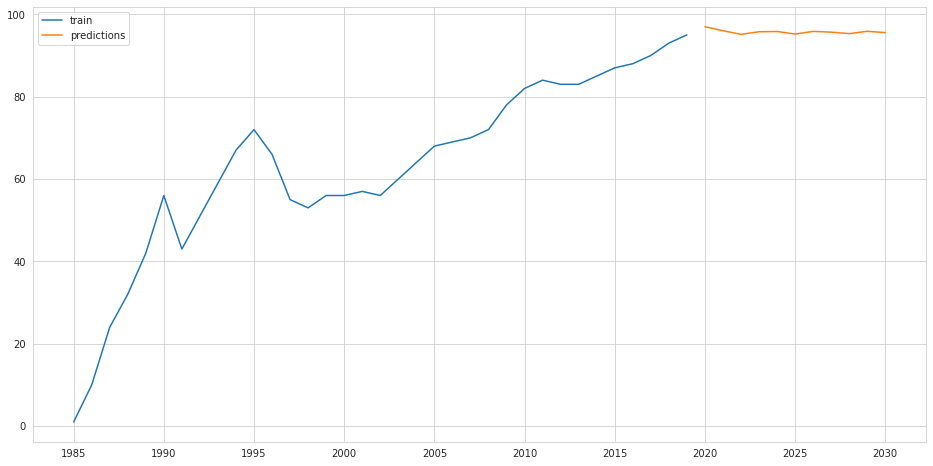

,Year,"Immunization, measles (% of children ages 12-23 months)"
0,2020,96.991425
1,2021,96.010540
2,2022,95.135438
3,2023,95.760389
4,2024,95.825529
5,2025,95.202432
6,2026,95.847586
7,2027,95.668306
8,2028,95.302986
9,2029,95.872509


In [360]:
India_df = full_df[full_df['Country'] == 'India']
India_measles = India_df[['Year', 'Immunization, measles (% of children ages 12-23 months)']].reset_index()
India_measles = India_measles.drop(columns= {'index'})
NaN = np.nan
India_measles.loc[len(India_measles.index)] = [2020, 0]
India_measles.loc[len(India_measles.index)] = [2021, 0]
India_measles.loc[len(India_measles.index)] = [2022, 0]
India_measles.loc[len(India_measles.index)] = [2023, 0]
India_measles.loc[len(India_measles.index)] = [2024, 0]
India_measles.loc[len(India_measles.index)] = [2025, 0]
India_measles.loc[len(India_measles.index)] = [2026, 0]
India_measles.loc[len(India_measles.index)] = [2027, 0]
India_measles.loc[len(India_measles.index)] = [2028, 0]
India_measles.loc[len(India_measles.index)] = [2029, 0]
India_measles.loc[len(India_measles.index)] = [2030, 0]
India_measles['Year'] = pd.to_datetime(India_measles['Year'], format='%Y')
India_measles = India_measles.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_measles['years_from_start'] = arr
x = India_measles['years_from_start'].values.reshape(-1, 1)
y = India_measles['Immunization, measles (% of children ages 12-23 months)'].values
train=India_measles[0:35] 
test=India_measles[34:]

dd= np.asarray(train['Immunization, measles (% of children ages 12-23 months)'])

y_hat_avg_measles = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Immunization, measles (% of children ages 12-23 months)'], order=(2, 1, 4)).fit()
y_hat_avg_measles['SARIMA'] = fit_arima.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Immunization, measles (% of children ages 12-23 months)'], label='train')
plt.plot(y_hat_avg_measles['SARIMA'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_measles['SARIMA']

y_hat_avg_measles = y_hat_avg_measles.iloc[1: , :]
y_hat_avg_measles = y_hat_avg_measles.drop(columns={'Immunization, measles (% of children ages 12-23 months)'})
y_hat_avg_measles = y_hat_avg_measles.rename(columns={'SARIMA': 'Immunization, measles (% of children ages 12-23 months)'})
y_hat_avg_measles['years_from_start'] = y_hat_avg_measles['years_from_start'] + 1985
y_hat_avg_measles = y_hat_avg_measles.reset_index()
y_hat_avg_measles = y_hat_avg_measles.drop(columns={'Year'})
y_hat_avg_measles = y_hat_avg_measles.rename(columns={'years_from_start': 'Year'})
y_hat_avg_measles

c

Life expectancy at birth, total (years) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


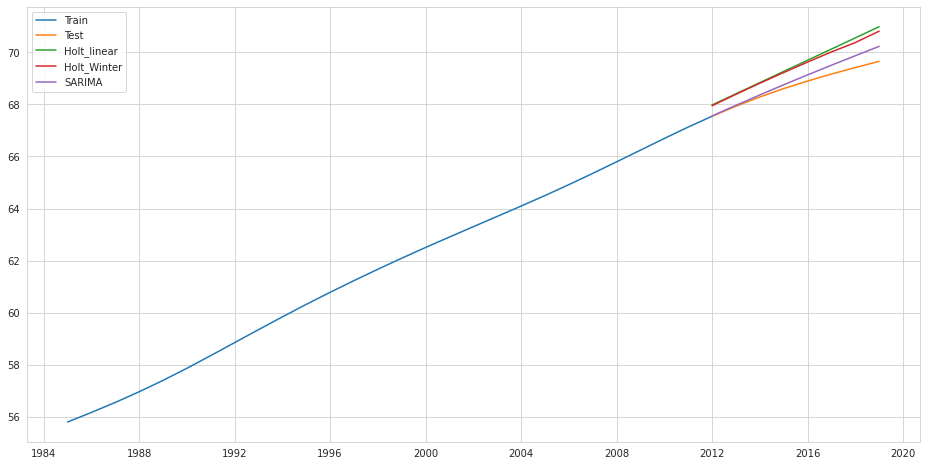

Holt Linear RMSE: 0.8498858890861596 Holt Winter RMSE 0.7542300412971298 ARIMA RMSE: 0.30347395819961676


In [361]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_life = India_df[['Year', 'Life expectancy at birth, total (years)']].reset_index()
India_life = India_life.drop(columns= {'index'})
India_life = India_life.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_life['years_from_start'] = arr
x = India_life['years_from_start'].values.reshape(-1, 1)
y = India_life['Life expectancy at birth, total (years)'].values
train=India_life[0:28] 
test=India_life[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Life expectancy at birth, total (years)'], label='Train')
plt.plot(test['Life expectancy at birth, total (years)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Life expectancy at birth, total (years)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Life expectancy at birth, total (years)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Life expectancy at birth, total (years)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Life expectancy at birth, total (years)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Life expectancy at birth, total (years)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Life expectancy at birth, total (years)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


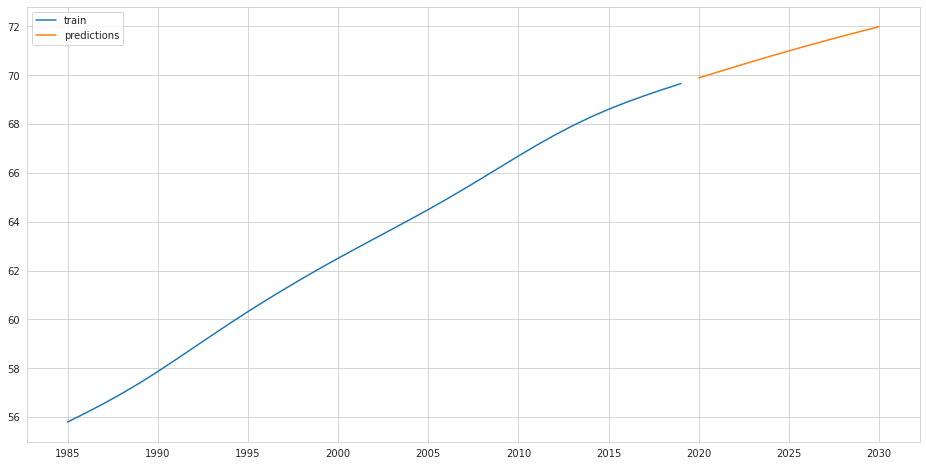

,Year,"Life expectancy at birth, total (years)"
0,2020,69.889903
1,2021,70.120026
2,2022,70.345974
3,2023,70.567893
4,2024,70.785411
5,2025,70.998254
6,2026,71.206231
7,2027,71.409219
8,2028,71.607145
9,2029,71.799981


In [362]:
India_df = full_df[full_df['Country'] == 'India']
India_life = India_df[['Year', 'Life expectancy at birth, total (years)']].reset_index()
India_life = India_life.drop(columns= {'index'})
NaN = np.nan
India_life.loc[len(India_life.index)] = [2020, 0]
India_life.loc[len(India_life.index)] = [2021, 0]
India_life.loc[len(India_life.index)] = [2022, 0]
India_life.loc[len(India_life.index)] = [2023, 0]
India_life.loc[len(India_life.index)] = [2024, 0]
India_life.loc[len(India_life.index)] = [2025, 0]
India_life.loc[len(India_life.index)] = [2026, 0]
India_life.loc[len(India_life.index)] = [2027, 0]
India_life.loc[len(India_life.index)] = [2028, 0]
India_life.loc[len(India_life.index)] = [2029, 0]
India_life.loc[len(India_life.index)] = [2030, 0]
India_life['Year'] = pd.to_datetime(India_life['Year'], format='%Y')
India_life = India_life.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_life['years_from_start'] = arr
x = India_life['years_from_start'].values.reshape(-1, 1)
y = India_life['Life expectancy at birth, total (years)'].values
train=India_life[0:35] 
test=India_life[34:]

dd= np.asarray(train['Life expectancy at birth, total (years)'])

y_hat_avg_life = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Life expectancy at birth, total (years)'], order=(2, 1, 4)).fit()
y_hat_avg_life['SARIMA'] = fit_arima.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Life expectancy at birth, total (years)'], label='train')
plt.plot(y_hat_avg_life['SARIMA'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_life['SARIMA']

y_hat_avg_life = y_hat_avg_life.iloc[1: , :]
y_hat_avg_life = y_hat_avg_life.drop(columns={'Life expectancy at birth, total (years)'})
y_hat_avg_life = y_hat_avg_life.rename(columns={'SARIMA': 'Life expectancy at birth, total (years)'})
y_hat_avg_life['years_from_start'] = y_hat_avg_life['years_from_start'] + 1985
y_hat_avg_life = y_hat_avg_life.reset_index()
y_hat_avg_life = y_hat_avg_life.drop(columns={'Year'})
y_hat_avg_life = y_hat_avg_life.rename(columns={'years_from_start': 'Year'})
y_hat_avg_life

Population growth (annual %)	Adjusted savings: education expenditure (% of GNI)	GDP per capita (current US$)	Individuals using the Internet (% of population)	Developed?

Mortality rate, under-5 (per 1,000 live births) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


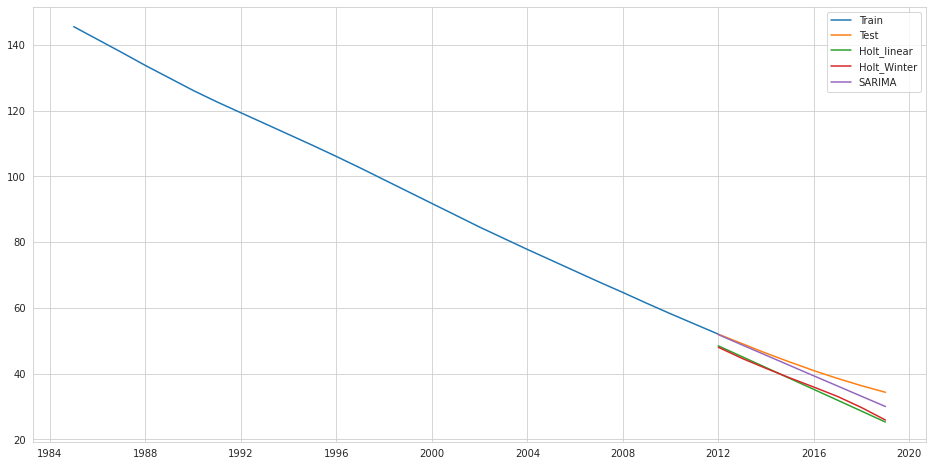

Holt Linear RMSE: 6.0342060693140285 Holt Winter RMSE 5.6052148941424225 ARIMA RMSE: 2.1977138889649823


In [363]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_mortality = India_df[['Year', 'Mortality rate, under-5 (per 1,000 live births)']].reset_index()
India_mortality = India_mortality.drop(columns= {'index'})
India_mortality = India_mortality.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_mortality['years_from_start'] = arr
x = India_mortality['years_from_start'].values.reshape(-1, 1)
y = India_mortality['Mortality rate, under-5 (per 1,000 live births)'].values
train=India_mortality[0:28] 
test=India_mortality[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Mortality rate, under-5 (per 1,000 live births)'], label='Train')
plt.plot(test['Mortality rate, under-5 (per 1,000 live births)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Mortality rate, under-5 (per 1,000 live births)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Mortality rate, under-5 (per 1,000 live births)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Mortality rate, under-5 (per 1,000 live births)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Mortality rate, under-5 (per 1,000 live births)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Mortality rate, under-5 (per 1,000 live births)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Mortality rate, under-5 (per 1,000 live births)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


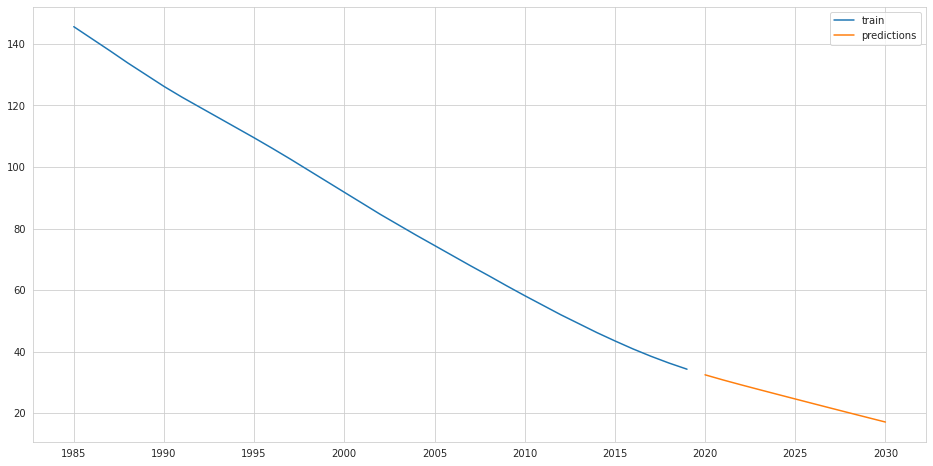

,Year,"Mortality rate, under-5 (per 1,000 live births)"
0,2020,32.477037
1,2021,30.801426
2,2022,29.214936
3,2023,27.672135
4,2024,26.143219
5,2025,24.622757
6,2026,23.109735
7,2027,21.603941
8,2028,20.105309
9,2029,18.613798


In [364]:
India_df = full_df[full_df['Country'] == 'India']
India_mortality = India_df[['Year', 'Mortality rate, under-5 (per 1,000 live births)']].reset_index()
India_mortality = India_mortality.drop(columns= {'index'})
NaN = np.nan
India_mortality.loc[len(India_mortality.index)] = [2020, 0]
India_mortality.loc[len(India_mortality.index)] = [2021, 0]
India_mortality.loc[len(India_mortality.index)] = [2022, 0]
India_mortality.loc[len(India_mortality.index)] = [2023, 0]
India_mortality.loc[len(India_mortality.index)] = [2024, 0]
India_mortality.loc[len(India_mortality.index)] = [2025, 0]
India_mortality.loc[len(India_mortality.index)] = [2026, 0]
India_mortality.loc[len(India_mortality.index)] = [2027, 0]
India_mortality.loc[len(India_mortality.index)] = [2028, 0]
India_mortality.loc[len(India_mortality.index)] = [2029, 0]
India_mortality.loc[len(India_mortality.index)] = [2030, 0]
India_mortality['Year'] = pd.to_datetime(India_mortality['Year'], format='%Y')
India_mortality = India_mortality.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_mortality['years_from_start'] = arr
x = India_mortality['years_from_start'].values.reshape(-1, 1)
y = India_mortality['Mortality rate, under-5 (per 1,000 live births)'].values
train=India_mortality[0:35] 
test=India_mortality[34:]

dd= np.asarray(train['Mortality rate, under-5 (per 1,000 live births)'])

y_hat_avg_mortality = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Mortality rate, under-5 (per 1,000 live births)'], order=(2, 1, 4)).fit()
y_hat_avg_mortality['SARIMA'] = fit_arima.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Mortality rate, under-5 (per 1,000 live births)'], label='train')
plt.plot(y_hat_avg_mortality['SARIMA'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_mortality['SARIMA']

y_hat_avg_mortality = y_hat_avg_mortality.iloc[1: , :]
y_hat_avg_mortality = y_hat_avg_mortality.drop(columns={'Mortality rate, under-5 (per 1,000 live births)'})
y_hat_avg_mortality = y_hat_avg_mortality.rename(columns={'SARIMA': 'Mortality rate, under-5 (per 1,000 live births)'})
y_hat_avg_mortality['years_from_start'] = y_hat_avg_mortality['years_from_start'] + 1985
y_hat_avg_mortality = y_hat_avg_mortality.reset_index()
y_hat_avg_mortality = y_hat_avg_mortality.drop(columns={'Year'})
y_hat_avg_mortality = y_hat_avg_mortality.rename(columns={'years_from_start': 'Year'})
y_hat_avg_mortality

Population growth (annual %) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

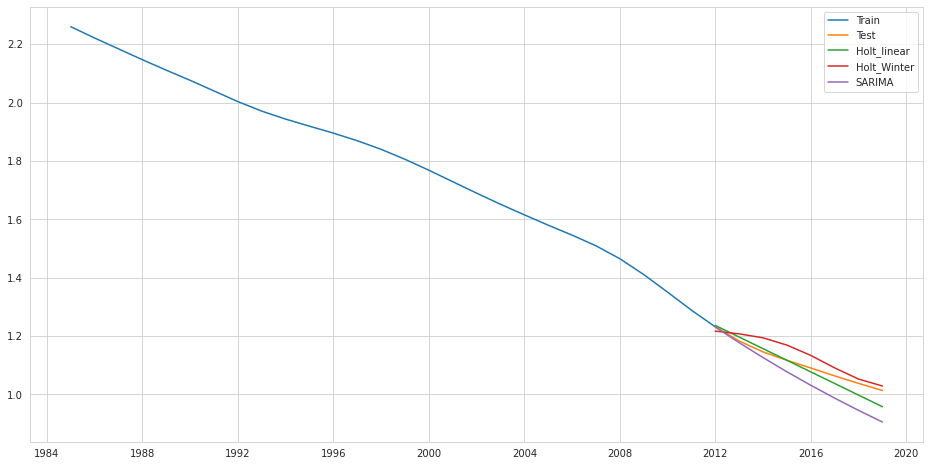

Holt Linear RMSE: 0.02709580915058068 Holt Winter RMSE 0.03336484772527106 ARIMA RMSE: 0.06274694150193859


In [365]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_population = India_df[['Year', 'Population growth (annual %)']].reset_index()
India_population = India_population.drop(columns= {'index'})
India_population = India_population.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_population['years_from_start'] = arr
x = India_population['years_from_start'].values.reshape(-1, 1)
y = India_population['Population growth (annual %)'].values
train=India_population[0:28] 
test=India_population[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Population growth (annual %)'], label='Train')
plt.plot(test['Population growth (annual %)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Population growth (annual %)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Population growth (annual %)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Population growth (annual %)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Population growth (annual %)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Population growth (annual %)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Population growth (annual %)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

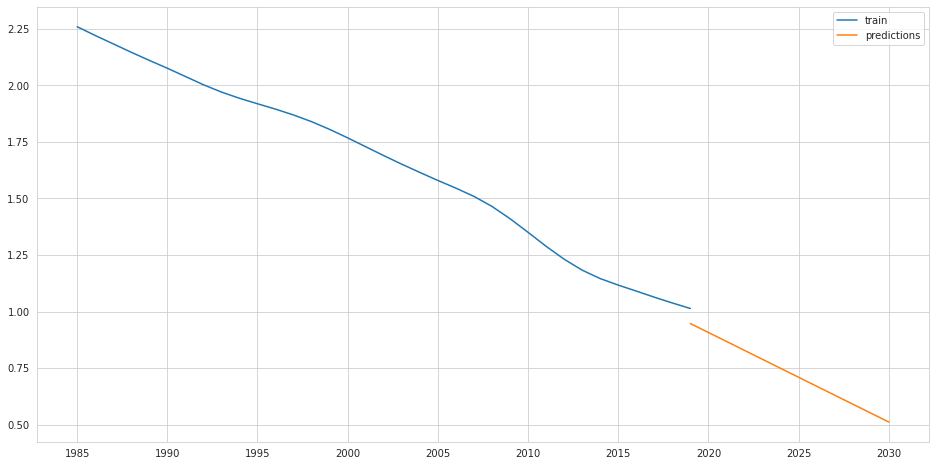

,Year,Population growth (annual %)
0,2020,0.907278
1,2021,0.867669
2,2022,0.828059
3,2023,0.788450
4,2024,0.748841
5,2025,0.709231
6,2026,0.669622
7,2027,0.630013
8,2028,0.590403
9,2029,0.550794


In [366]:
India_df = full_df[full_df['Country'] == 'India']
India_population = India_df[['Year', 'Population growth (annual %)']].reset_index()
India_population = India_population.drop(columns= {'index'})
NaN = np.nan
India_population.loc[len(India_population.index)] = [2020, 0]
India_population.loc[len(India_population.index)] = [2021, 0]
India_population.loc[len(India_population.index)] = [2022, 0]
India_population.loc[len(India_population.index)] = [2023, 0]
India_population.loc[len(India_population.index)] = [2024, 0]
India_population.loc[len(India_population.index)] = [2025, 0]
India_population.loc[len(India_population.index)] = [2026, 0]
India_population.loc[len(India_population.index)] = [2027, 0]
India_population.loc[len(India_population.index)] = [2028, 0]
India_population.loc[len(India_population.index)] = [2029, 0]
India_population.loc[len(India_population.index)] = [2030, 0]
India_population['Year'] = pd.to_datetime(India_population['Year'], format='%Y')
India_population = India_population.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_population['years_from_start'] = arr
x = India_population['years_from_start'].values.reshape(-1, 1)
y = India_population['Population growth (annual %)'].values
train=India_population[0:35] 
test=India_population[34:]

dd= np.asarray(train['Population growth (annual %)'])

y_hat_avg_population = test.copy()
fit_holt_linear = Holt(np.asarray(train['Population growth (annual %)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg_population['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Population growth (annual %)'], label='train')
plt.plot(y_hat_avg_population['Holt_linear'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_population['Holt_linear']

y_hat_avg_population = y_hat_avg_population.iloc[1: , :]
y_hat_avg_population = y_hat_avg_population.drop(columns={'Population growth (annual %)'})
y_hat_avg_population = y_hat_avg_population.rename(columns={'Holt_linear': 'Population growth (annual %)'})
y_hat_avg_population['years_from_start'] = y_hat_avg_population['years_from_start'] + 1985
y_hat_avg_population = y_hat_avg_population.reset_index()
y_hat_avg_population = y_hat_avg_population.drop(columns={'Year'})
y_hat_avg_population = y_hat_avg_population.rename(columns={'years_from_start': 'Year'})
y_hat_avg_population

Adjusted savings: education expenditure (% of GNI) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


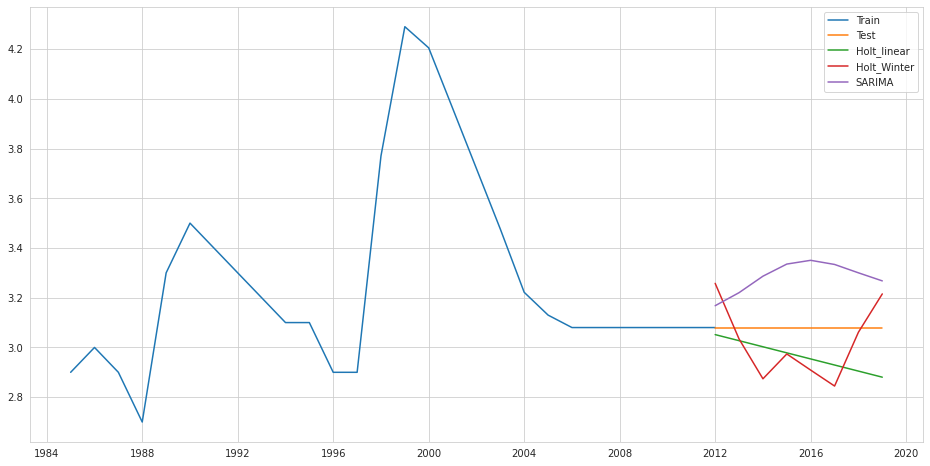

Holt Linear RMSE: 0.12703300234192852 Holt Winter RMSE 0.15443591606007898 ARIMA RMSE: 0.2110750536965896


In [367]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_education = India_df[['Year', 'Adjusted savings: education expenditure (% of GNI)']].reset_index()
India_education = India_education.drop(columns= {'index'})
India_education = India_education.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_education['years_from_start'] = arr
x = India_education['years_from_start'].values.reshape(-1, 1)
y = India_education['Adjusted savings: education expenditure (% of GNI)'].values
train=India_education[0:28] 
test=India_education[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Adjusted savings: education expenditure (% of GNI)'], label='Train')
plt.plot(test['Adjusted savings: education expenditure (% of GNI)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Adjusted savings: education expenditure (% of GNI)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Adjusted savings: education expenditure (% of GNI)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Adjusted savings: education expenditure (% of GNI)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Adjusted savings: education expenditure (% of GNI)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Adjusted savings: education expenditure (% of GNI)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Adjusted savings: education expenditure (% of GNI)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

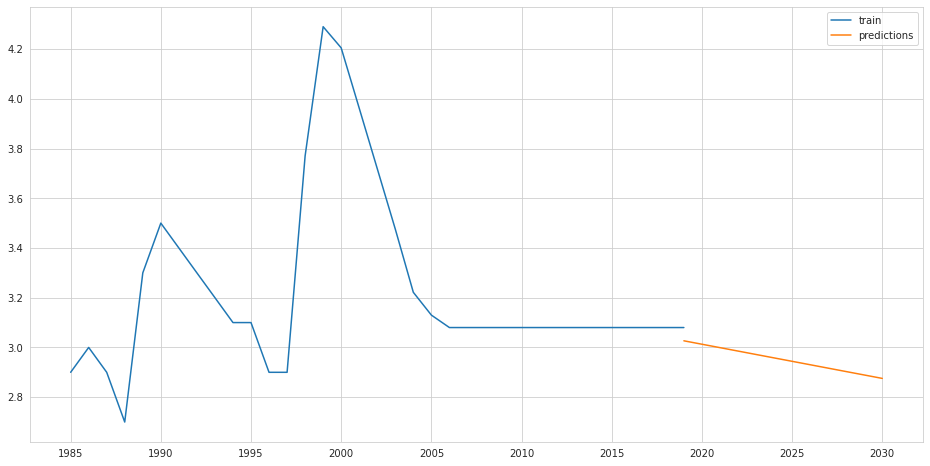

,Year,Adjusted savings: education expenditure (% of GNI)
0,2020,3.012926
1,2021,2.999178
2,2022,2.985430
3,2023,2.971682
4,2024,2.957935
5,2025,2.944187
6,2026,2.930439
7,2027,2.916691
8,2028,2.902944
9,2029,2.889196


In [368]:
India_df = full_df[full_df['Country'] == 'India']
India_education = India_df[['Year', 'Adjusted savings: education expenditure (% of GNI)']].reset_index()
India_education = India_education.drop(columns= {'index'})
NaN = np.nan
India_education.loc[len(India_education.index)] = [2020, 0]
India_education.loc[len(India_education.index)] = [2021, 0]
India_education.loc[len(India_education.index)] = [2022, 0]
India_education.loc[len(India_education.index)] = [2023, 0]
India_education.loc[len(India_education.index)] = [2024, 0]
India_education.loc[len(India_education.index)] = [2025, 0]
India_education.loc[len(India_education.index)] = [2026, 0]
India_education.loc[len(India_education.index)] = [2027, 0]
India_education.loc[len(India_education.index)] = [2028, 0]
India_education.loc[len(India_education.index)] = [2029, 0]
India_education.loc[len(India_education.index)] = [2030, 0]
India_education['Year'] = pd.to_datetime(India_education['Year'], format='%Y')
India_education = India_education.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_education['years_from_start'] = arr
x = India_education['years_from_start'].values.reshape(-1, 1)
y = India_education['Adjusted savings: education expenditure (% of GNI)'].values
train=India_education[0:35] 
test=India_education[34:]

dd= np.asarray(train['Adjusted savings: education expenditure (% of GNI)'])

y_hat_avg_education = test.copy()
fit_holt_linear = Holt(np.asarray(train['Adjusted savings: education expenditure (% of GNI)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg_education['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Adjusted savings: education expenditure (% of GNI)'], label='train')
plt.plot(y_hat_avg_education['Holt_linear'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_education['Holt_linear']

y_hat_avg_education = y_hat_avg_education.iloc[1: , :]
y_hat_avg_education = y_hat_avg_education.drop(columns={'Adjusted savings: education expenditure (% of GNI)'})
y_hat_avg_education = y_hat_avg_education.rename(columns={'Holt_linear': 'Adjusted savings: education expenditure (% of GNI)'})
y_hat_avg_education['years_from_start'] = y_hat_avg_education['years_from_start'] + 1985
y_hat_avg_education = y_hat_avg_education.reset_index()
y_hat_avg_education = y_hat_avg_education.drop(columns={'Year'})
y_hat_avg_education = y_hat_avg_education.rename(columns={'years_from_start': 'Year'})
y_hat_avg_education

GDP per capita (current US$) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmode

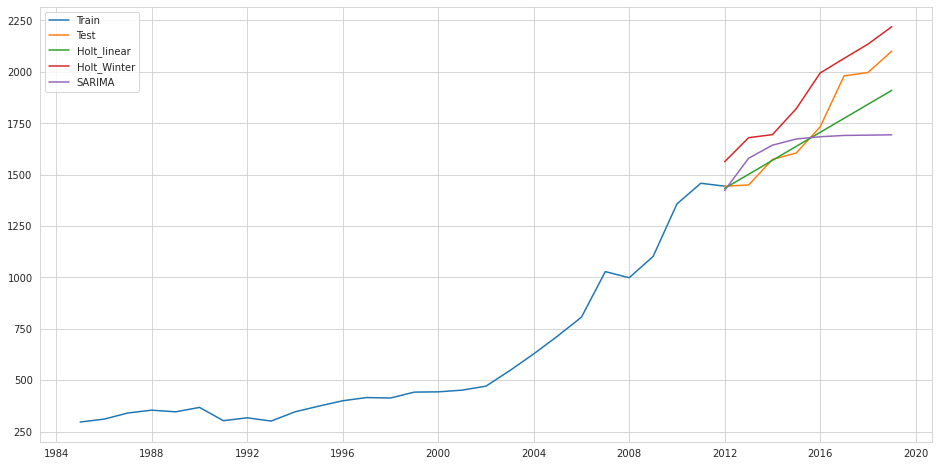

Holt Linear RMSE: 115.98937297795578 Holt Winter RMSE 172.22459905228155 ARIMA RMSE: 215.5539777823231


In [369]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_gdp = India_df[['Year', 'GDP per capita (current US$)']].reset_index()
India_gdp = India_gdp.drop(columns= {'index'})
India_gdp = India_gdp.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_gdp['years_from_start'] = arr
x = India_gdp['years_from_start'].values.reshape(-1, 1)
y = India_gdp['GDP per capita (current US$)'].values
train=India_gdp[0:28] 
test=India_gdp[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['GDP per capita (current US$)'], label='Train')
plt.plot(test['GDP per capita (current US$)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['GDP per capita (current US$)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['GDP per capita (current US$)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['GDP per capita (current US$)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['GDP per capita (current US$)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['GDP per capita (current US$)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['GDP per capita (current US$)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

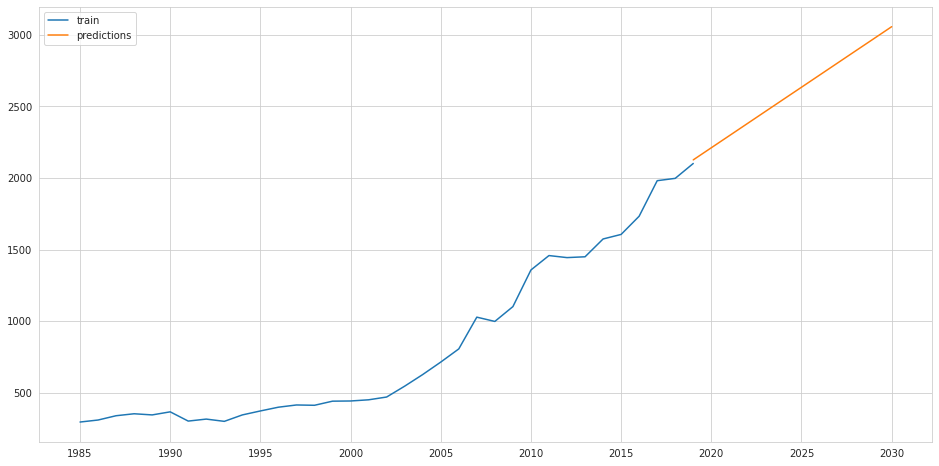

,Year,GDP per capita (current US$)
0,2020,2210.331691
1,2021,2294.831104
2,2022,2379.330517
3,2023,2463.829931
4,2024,2548.329344
5,2025,2632.828757
6,2026,2717.328171
7,2027,2801.827584
8,2028,2886.326997
9,2029,2970.826411


In [370]:
India_df = full_df[full_df['Country'] == 'India']
India_gdp = India_df[['Year', 'GDP per capita (current US$)']].reset_index()
India_gdp = India_gdp.drop(columns= {'index'})
NaN = np.nan
India_gdp.loc[len(India_gdp.index)] = [2020, 0]
India_gdp.loc[len(India_gdp.index)] = [2021, 0]
India_gdp.loc[len(India_gdp.index)] = [2022, 0]
India_gdp.loc[len(India_gdp.index)] = [2023, 0]
India_gdp.loc[len(India_gdp.index)] = [2024, 0]
India_gdp.loc[len(India_gdp.index)] = [2025, 0]
India_gdp.loc[len(India_gdp.index)] = [2026, 0]
India_gdp.loc[len(India_gdp.index)] = [2027, 0]
India_gdp.loc[len(India_gdp.index)] = [2028, 0]
India_gdp.loc[len(India_gdp.index)] = [2029, 0]
India_gdp.loc[len(India_gdp.index)] = [2030, 0]
India_gdp['Year'] = pd.to_datetime(India_gdp['Year'], format='%Y')
India_gdp = India_gdp.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_gdp['years_from_start'] = arr
x = India_gdp['years_from_start'].values.reshape(-1, 1)
y = India_gdp['GDP per capita (current US$)'].values
train=India_gdp[0:35] 
test=India_gdp[34:]

dd= np.asarray(train['GDP per capita (current US$)'])

y_hat_avg_gdp = test.copy()
fit_holt_linear = Holt(np.asarray(train['GDP per capita (current US$)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg_gdp['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['GDP per capita (current US$)'], label='train')
plt.plot(y_hat_avg_gdp['Holt_linear'], label='predictions')
plt.legend(loc='best')
plt.show()
y_hat_avg_gdp['Holt_linear']

y_hat_avg_gdp = y_hat_avg_gdp.iloc[1: , :]
y_hat_avg_gdp = y_hat_avg_gdp.drop(columns={'GDP per capita (current US$)'})
y_hat_avg_gdp = y_hat_avg_gdp.rename(columns={'Holt_linear': 'GDP per capita (current US$)'})
y_hat_avg_gdp['years_from_start'] = y_hat_avg_gdp['years_from_start'] + 1985
y_hat_avg_gdp = y_hat_avg_gdp.reset_index()
y_hat_avg_gdp = y_hat_avg_gdp.drop(columns={'Year'})
y_hat_avg_gdp = y_hat_avg_gdp.rename(columns={'years_from_start': 'Year'})
y_hat_avg_gdp

Individuals using the Internet (% of population) Future Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


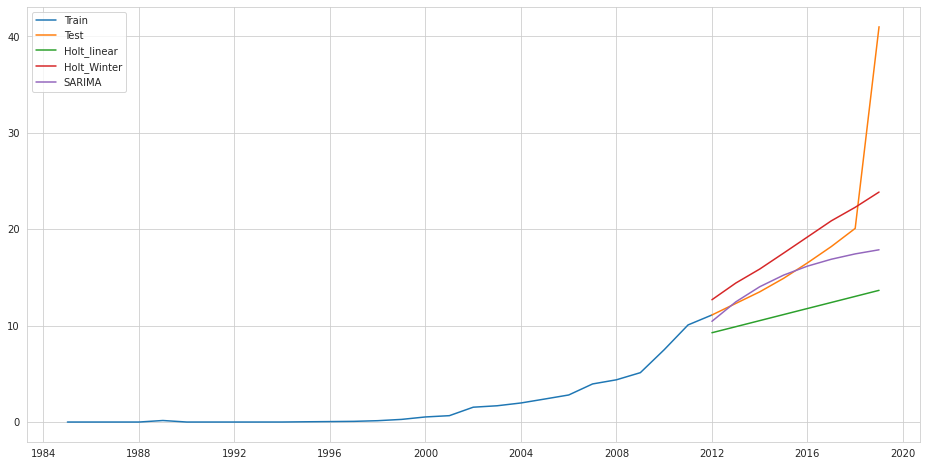

Holt Linear RMSE: 10.521051926899156 Holt Winter RMSE 6.448529821707515 ARIMA RMSE: 8.25381314336388


In [371]:
India_df = full_df[full_df['Country'] == 'India']
India_df['Year'] = pd.to_datetime(India_df['Year'], format='%Y')
India_internet = India_df[['Year', 'Individuals using the Internet (% of population)']].reset_index()
India_internet = India_internet.drop(columns= {'index'})
India_internet = India_internet.set_index('Year')

lst = list(range(0,35))
arr = np.array(lst)
India_internet['years_from_start'] = arr
x = India_internet['years_from_start'].values.reshape(-1, 1)
y = India_internet['Individuals using the Internet (% of population)'].values
train=India_internet[0:28] 
test=India_internet[27:]
y_hat_avg = test.copy()
plt.figure(figsize=(16,8))
plt.plot(train['Individuals using the Internet (% of population)'], label='Train')
plt.plot(test['Individuals using the Internet (% of population)'], label='Test')
#Holt Linear 
y_hat_avg = test.copy()
fit_holt_linear = Holt(np.asarray(train['Individuals using the Internet (% of population)'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit_holt_linear.forecast(len(test))
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
rms_holt_linear = sqrt(mean_squared_error(test['Individuals using the Internet (% of population)'], y_hat_avg.Holt_linear))
#Holt Winter
y_hat_avg = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Individuals using the Internet (% of population)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
rms_holt_winter = sqrt(mean_squared_error(test['Individuals using the Internet (% of population)'], y_hat_avg.Holt_Winter))
#ARIMA
y_hat_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train['Individuals using the Internet (% of population)'], order=(2, 1, 4)).fit()
y_hat_avg['SARIMA'] = fit_arima.predict(start="2011-01-01", end="2019-01-01", dynamic=True)
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
rms_arima = sqrt(mean_squared_error(test['Individuals using the Internet (% of population)'], y_hat_avg.SARIMA))
print("Holt Linear RMSE:", rms_holt_linear, "Holt Winter RMSE", rms_holt_winter, "ARIMA RMSE:", rms_arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


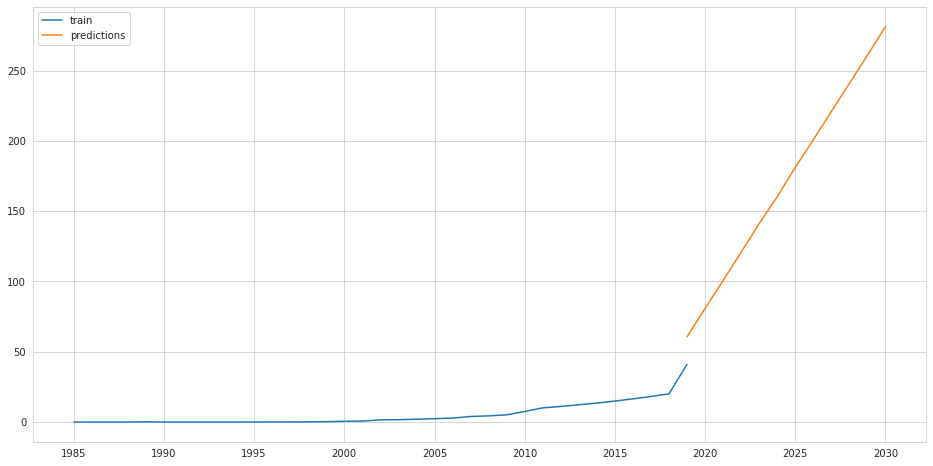

,Year,Individuals using the Internet (% of population)
0,2020,80.779241
1,2021,100.683079
2,2022,120.794027
3,2023,141.179639
4,2024,160.202048
5,2025,181.120743
6,2026,200.782650
7,2027,220.899987
8,2028,240.803824
9,2029,260.914773


In [372]:
India_df = full_df[full_df['Country'] == 'India']
India_internet = India_df[['Year', 'Individuals using the Internet (% of population)']].reset_index()
India_internet = India_internet.drop(columns= {'index'})
NaN = np.nan

India_internet.loc[len(India_internet.index)] = [2020, 0]
India_internet.loc[len(India_internet.index)] = [2021, 0]
India_internet.loc[len(India_internet.index)] = [2022, 0]
India_internet.loc[len(India_internet.index)] = [2023, 0]
India_internet.loc[len(India_internet.index)] = [2024, 0]
India_internet.loc[len(India_internet.index)] = [2025, 0]
India_internet.loc[len(India_internet.index)] = [2026, 0]
India_internet.loc[len(India_internet.index)] = [2027, 0]
India_internet.loc[len(India_internet.index)] = [2028, 0]
India_internet.loc[len(India_internet.index)] = [2029, 0]
India_internet.loc[len(India_internet.index)] = [2030, 0]
India_internet['Year'] = pd.to_datetime(India_internet['Year'], format='%Y')
India_internet = India_internet.set_index('Year')
lst = list(range(0,46))
arr = np.array(lst)
India_internet['years_from_start'] = arr
x = India_internet['years_from_start'].values.reshape(-1, 1)
y = India_internet['Individuals using the Internet (% of population)'].values
train=India_internet[0:35] 
test=India_internet[34:]

dd= np.asarray(train['Individuals using the Internet (% of population)'])

y_hat_avg_internet = test.copy()
fit_holt_winter = ExponentialSmoothing(np.asarray(train['Individuals using the Internet (% of population)']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg_internet['Holt_Winter'] = fit_holt_winter.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Individuals using the Internet (% of population)'], label='train')
plt.plot(y_hat_avg_internet['Holt_Winter'], label='predictions')
plt.legend(loc='best')
plt.show()

y_hat_avg_internet = y_hat_avg_internet.iloc[1: , :]
y_hat_avg_internet = y_hat_avg_internet.drop(columns={'Individuals using the Internet (% of population)'})
y_hat_avg_internet = y_hat_avg_internet.rename(columns={'Holt_Winter': 'Individuals using the Internet (% of population)'})
y_hat_avg_internet['years_from_start'] = y_hat_avg_internet['years_from_start'] + 1985
y_hat_avg_internet = y_hat_avg_internet.reset_index()
y_hat_avg_internet = y_hat_avg_internet.drop(columns={'Year'})
y_hat_avg_internet = y_hat_avg_internet.rename(columns={'years_from_start': 'Year'})
y_hat_avg_internet

In [373]:
predictions_df = y_hat_avg_c02
predictions_df['Renewable energy consumption (% of total final energy consumption)'] = y_hat_avg_energy['Renewable energy consumption (% of total final energy consumption)']
predictions_df['rural'] = y_hat_avg_rural['rural']
predictions_df['Birth rate, crude (per 1,000 people)'] = y_hat_avg_birth['Birth rate, crude (per 1,000 people)']
predictions_df['immunization'] = y_hat_avg_immunization['immunization']
predictions_df['Immunization, measles (% of children ages 12-23 months)'] = y_hat_avg_measles['Immunization, measles (% of children ages 12-23 months)']
predictions_df['Life expectancy at birth, total (years)'] = y_hat_avg_life['Life expectancy at birth, total (years)']
predictions_df['Mortality rate, under-5 (per 1,000 live births)'] = y_hat_avg_mortality['Mortality rate, under-5 (per 1,000 live births)']
predictions_df['Population growth (annual %)'] = y_hat_avg_population['Population growth (annual %)']
predictions_df['Adjusted savings: education expenditure (% of GNI)'] = y_hat_avg_education['Adjusted savings: education expenditure (% of GNI)']
predictions_df['GDP per capita (current US$)'] = y_hat_avg_gdp['GDP per capita (current US$)']
predictions_df['Individuals using the Internet (% of population)'] = y_hat_avg_internet['Individuals using the Internet (% of population)']
predictions_df

,Year,CO2 emissions (metric tons per capita),Renewable energy consumption (% of total final energy consumption),rural,"Birth rate, crude (per 1,000 people)",immunization,"Immunization, measles (% of children ages 12-23 months)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)",Population growth (annual %),Adjusted savings: education expenditure (% of GNI),GDP per capita (current US$),Individuals using the Internet (% of population)
0,2020,5.235471,65.487840,65.081139,17.443252,93.774419,96.991425,69.889903,32.477037,0.907278,3.012926,2210.331691,80.779241
1,2021,5.980879,64.551770,64.633910,17.259194,96.123593,96.010540,70.120026,30.801426,0.867669,2.999178,2294.831104,100.683079
2,2022,6.744815,66.144590,64.187055,17.094408,98.066214,95.135438,70.345974,29.214936,0.828059,2.985430,2379.330517,120.794027
3,2023,7.573741,62.308872,63.741128,16.948325,100.567507,95.760389,70.567893,27.672135,0.788450,2.971682,2463.829931,141.179639
4,2024,8.464568,55.428133,63.295956,16.819593,102.985490,95.825529,70.785411,26.143219,0.748841,2.957935,2548.329344,160.202048
5,2025,9.487515,47.885929,62.851694,16.706848,105.912300,95.202432,70.998254,24.622757,0.709231,2.944187,2632.828757,181.120743
6,2026,10.412682,41.538364,62.408199,16.608734,106.648076,95.847586,71.206231,23.109735,0.669622,2.930439,2717.328171,200.782650
7,2027,11.325442,37.452440,61.965597,16.523931,107.452828,95.668306,71.409219,21.603941,0.630013,2.916691,2801.827584,220.899987
8,2028,12.070850,35.893007,61.523770,16.451160,109.802002,95.302986,71.607145,20.105309,0.590403,2.902944,2886.326997,240.803824
9,2029,12.834786,36.490925,61.082824,16.389204,111.744623,95.872509,71.799981,18.613798,0.550794,2.889196,2970.826411,260.914773


In [374]:
dataset = predictions_df.values
X = dataset[:,1:13]
min_max_scaler = preprocessing.MinMaxScaler()
predictions_scale = min_max_scaler.fit_transform(X)
final_predictions = model.predict(predictions_scale)

Now we go and use our previous neural net to predict values of development for India from 2020-2030 using the 12 indicator variables we calcualted using the methods explained above. 


In [376]:
final_predictions

array([[4.5092030e-08],
       [6.9763922e-07],
       [8.2729821e-06],
       [6.6903587e-05],
       [2.3241937e-03],
       [1.7276603e-01],
       [9.3312144e-01],
       [9.8856831e-01],
       [9.9694085e-01],
       [9.9931240e-01],
       [9.9976802e-01]], dtype=float32)

In [377]:
final_predictions_df = pd.DataFrame(final_predictions, columns = {'Prediction'})
final_predictions_df['Prediction'] = final_predictions_df['Prediction'].apply(lambda x : 1 if x > 0.5 else 0)
final_predictions_df['Year'] = predictions_df['Year']
final_predictions_df = final_predictions_df.set_index('Year')
final_predictions_df

,Prediction
Year,
2020,0
2021,0
2022,0
2023,0
2024,0
2025,0
2026,1
2027,1
2028,1


As the 0s turn into 1s through our neural net predictions after 2026, we predict that India will become a developed country by 2026 based on our 12 indicators!